# Exploring Climate Change using Climate models.
## by: Nina Hall


In [1]:
#Load in packages
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr  # to read in Zarr format
import gcsfs # to read google cloud data
import momlevel as ml
import cftime
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colormaps

In [2]:
# Make our figures appear clearly
xr.set_options(display_style='html')
%matplotlib inline                           
%config InlineBackend.figure_format='retina' 
plt.rcParams['figure.figsize'] = 12,6  

### Climate models are computer simulations that represent Earth’s climate system. By using science researchers can replicate how different climate systems in earth’s atmosphere interact. 

#### CMIP is the Coupled Model Intercomparison Project Phase 6. This is a combined international dataset that provides climate model simulations to compare how different models respond to historical and projected forcing. CMIP6 Simulations form the foundation of the IPCC 6th Assessment Report and are widely used to project future climate change and address uncertainty across models. 
In this notebook I will:
- Use real Climate data from [CMIP6].(https://console.cloud.google.com/marketplace/product/noaa-public/cmip6)
- Compare future **greenhouse gas** (GHG) emission scenarios, **SSPs**.
- Visualize temperature changes across time, latitude, and height

(Eyring, et al., 2016)

## SSPs or Shared Socioeconomic Pathways are the combined results of socioeconomic and emissions scenarios that have been designed to be used for climate science. SSPs have five distinct pathways for global development. Each pathway makes assumptions about future population, urbanization, economic growth, technology development and international cooperation.  We will only be using 2 of those SSPs today:
- SSP2 is described as the middle of the road. This path assumes that trends that are analogous with trends of recent decades will continue. This means uneven development among low-income countries, historic rates of reduction in resource and energy intensity, and slow decreases in fossil fuel dependency.
- SP5 is described as conventional development. This path prioritizes development focused on economic growth, this leads to an energy system totally dominated by fossil fuels and high GHG emissions.
- We use 2 different models in this project and use historical data as well as SSP scenarios.

(International Institute for Applied Systems Analysis Supplemental Note)

## Additional information about SSPs and links to the models used in this project 
- Model links for GFDL-CM4
  - [More Model Info](10.1029/2019MS001829)
  - [Historic](https://doi.org/10.22033/ESGF/CMIP6.8594)
  - [SSP2-45](https://doi.org/10.22033/ESGF/CMIP6.9263)
  - [SSP5-85](https://doi.org/10.22033/ESGF/CMIP6.9268)
- Model links for GFDL-ESM4
  -  [More Model Info](https://doi.org/10.26050/WDCC/AR6.C6SPNGGFL)
  - [Historic]( https://doi.org/10.22033/ESGF/CMIP6.8597)
  - [SSP2-45](https://doi.org/10.26050/WDCC/AR6.C6SPNGGFLs245)
  - [SSP5-85]( https://doi.org/10.22033/ESGF/CMIP6.8706)

In [3]:
#load in the google cloud
google_cloud_cmip6 = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

In [4]:
#examine out data
google_cloud_cmip6

activity_id       institution_id      source_id       experiment_id  \
0       HighResMIP                 CMCC   CMCC-CM2-HR4  highresSST-present   
1       HighResMIP                 CMCC   CMCC-CM2-HR4  highresSST-present   
2       HighResMIP                 CMCC   CMCC-CM2-HR4  highresSST-present   
3       HighResMIP                 CMCC   CMCC-CM2-HR4  highresSST-present   
4       HighResMIP                 CMCC   CMCC-CM2-HR4  highresSST-present   
...            ...                  ...            ...                 ...   
523769        CMIP  EC-Earth-Consortium  EC-Earth3-Veg          historical   
523770        CMIP  EC-Earth-Consortium  EC-Earth3-Veg          historical   
523771        CMIP  EC-Earth-Consortium  EC-Earth3-Veg          historical   
523772        CMIP  EC-Earth-Consortium  EC-Earth3-Veg          historical   
523773        CMIP  EC-Earth-Consortium  EC-Earth3-Veg          historical   

       member_id table_id variable_id grid_label  \
0       r1i1p1f1     Amon          ps         gn   
1       r1i1p1f1     Amon        rsds         gn   
2       r1i1p1f1     Amon        rlus         gn   
3       r1i1p1f1     Amon        rlds         gn   
4       r1i1p1f1     Amon         psl         gn   
...          ...      ...         ...        ...   
523769  r1i1p1f1     Amon         tas         gr   
523770  r1i1p1f1     Amon        tauu         gr   
523771  r1i1p1f1     Amon         hur         gr   
523772  r1i1p1f1     Amon         hus         gr   
523773  r1i1p1f1     Amon        tauv         gr   

                                                   zstore  dcpp_init_year  \
0       gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN   
1       gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN   
2       gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN   
3       gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN   
4       gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN   
...                                                   ...             ...   
523769  gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...             NaN   
523770  gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...             NaN   
523771  gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...             NaN   
523772  gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...             NaN   
523773  gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...             NaN   

         version  
0       20170706  
1       20170706  
2       20170706  
3       20170706  
4       20170706  
...          ...  
523769  20211207  
523770  20211207  
523771  20211207  
523772  20211207  
523773  20211207  

[523774 rows x 11 columns]

In [5]:
#Search for data
gfdl_cm4_H_tos_data = google_cloud_cmip6.query(
    "source_id == 'GFDL-CM4' & \
    table_id == 'Amon' & \
    variable_id == 'tas' & \
    experiment_id == 'historical' & \
    member_id == 'r1i1p1f1' & \
    grid_label == 'gr1' "
)

gfdl_cm4_H_tos_data

gfdl_cm4_24_tos_data = google_cloud_cmip6.query(
    "source_id == 'GFDL-CM4' & \
     table_id == 'Amon' & \
    variable_id == 'tas' & \
    experiment_id == 'ssp245' & \
    member_id == 'r1i1p1f1' & \
    grid_label == 'gr1' "
)

gfdl_cm4_24_tos_data

gfdl_cm4_54_tos_data = google_cloud_cmip6.query(
    "source_id == 'GFDL-CM4' & \
    table_id == 'Amon' & \
    variable_id == 'tas' & \
    experiment_id == 'ssp585' & \
    member_id == 'r1i1p1f1' & \
    grid_label == 'gr1' "
)

gfdl_cm4_54_tos_data

activity_id institution_id source_id experiment_id member_id table_id  \
866  ScenarioMIP      NOAA-GFDL  GFDL-CM4        ssp585  r1i1p1f1     Amon   

    variable_id grid_label                                             zstore  \
866         tas        gr1  gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-CM...   

     dcpp_init_year   version  
866             NaN  20180701

In [6]:
#Search for data
gfdl_ESM4_h_data = google_cloud_cmip6.query(
    "source_id == 'GFDL-ESM4' & \
    table_id == 'Amon' & \
    variable_id == 'tas' & \
    experiment_id == 'historical' & \
    member_id == 'r1i1p1f1' & \
    grid_label == 'gr1' "
)

gfdl_ESM4_h_data 

gfdl_esm4_tos_58_data = google_cloud_cmip6.query(
    "source_id == 'GFDL-ESM4' & \
    table_id == 'Amon' & \
    variable_id == 'tas' & \
    experiment_id == 'ssp585' & \
    member_id == 'r1i1p1f1' & \
    grid_label == 'gr1' "
)

gfdl_esm4_tos_58_data

gfdl_esm4_tos_24_data = google_cloud_cmip6.query(
    "source_id == 'GFDL-ESM4' & \
    table_id == 'Amon' & \
    variable_id == 'tas' & \
    experiment_id == 'ssp245' & \
    member_id == 'r1i1p1f1' & \
    grid_label == 'gr1' "
)

gfdl_esm4_tos_24_data

activity_id institution_id  source_id experiment_id member_id table_id  \
15454  ScenarioMIP      NOAA-GFDL  GFDL-ESM4        ssp245  r1i1p1f1     Amon   

      variable_id grid_label  \
15454         tas        gr1   

                                                  zstore  dcpp_init_year  \
15454  gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...             NaN   

        version  
15454  20180701

### Load in for GFDL CM4

In [7]:
#Search for data
gfdl_cm4_H_tao_data = google_cloud_cmip6.query(
    "source_id == 'GFDL-CM4' & \
    variable_id == 'ta' & \
    table_id == 'Amon' & \
    experiment_id == 'historical' & \
    member_id == 'r1i1p1f1' "
)

gfdl_cm4_H_tao_data

gfdl_cm4_245_tao_data =  google_cloud_cmip6.query(
    "source_id == 'GFDL-CM4' & \
    table_id == 'Amon' & \
    variable_id == 'ta' & \
    experiment_id == 'ssp245' & \
    member_id == 'r1i1p1f1'  "
)
gfdl_cm4_245_tao_data

gfdl_cm4_54_tao_data = google_cloud_cmip6.query(
    "source_id == 'GFDL-CM4' & \
    table_id == 'Amon' & \
    variable_id == 'ta' & \
    experiment_id == 'ssp585' & \
    member_id == 'r1i1p1f1'  "
)

gfdl_cm4_54_tao_data

activity_id institution_id source_id experiment_id member_id table_id  \
850  ScenarioMIP      NOAA-GFDL  GFDL-CM4        ssp585  r1i1p1f1     Amon   

    variable_id grid_label                                             zstore  \
850          ta        gr1  gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-CM...   

     dcpp_init_year   version  
850             NaN  20180701

In [8]:
#Search for data
gfdl_ESM4_H_tao_data = google_cloud_cmip6.query(
    "source_id == 'GFDL-ESM4' & \
    table_id == 'Amon' & \
    variable_id == 'ta' & \
    experiment_id == 'historical' & \
    member_id == 'r1i1p1f1'  "
)

gfdl_ESM4_H_tao_data

gfdl_ESM4_245_tao_data = google_cloud_cmip6.query(
    "source_id == 'GFDL-ESM4' & \
    table_id == 'Amon' & \
    variable_id == 'ta' & \
    experiment_id == 'ssp245' & \
    member_id == 'r1i1p1f1' "
)

gfdl_ESM4_245_tao_data

gfdl_ESM4_585_tao_data = google_cloud_cmip6.query(
    "source_id == 'GFDL-ESM4' & \
    table_id == 'Amon' & \
    variable_id == 'ta' & \
    experiment_id == 'ssp585' & \
    member_id == 'r1i1p1f1' "
)

gfdl_ESM4_585_tao_data

activity_id institution_id  source_id experiment_id member_id table_id  \
19007  ScenarioMIP      NOAA-GFDL  GFDL-ESM4        ssp585  r1i1p1f1     Amon   

      variable_id grid_label  \
19007          ta        gr1   

                                                  zstore  dcpp_init_year  \
19007  gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...             NaN   

        version  
19007  20180701

In [9]:
#Search for data
gfdl_ESM4_h_fx_data = google_cloud_cmip6.query(
    "source_id == 'GFDL-ESM4' & \
    table_id == 'fx' & \
    experiment_id == 'land-hist' & \
    variable_id == 'sftlf' & \
    member_id == 'r1i1p1f1' "
)

gfdl_ESM4_h_fx_data

gfdl_CM4_h_fx_data = google_cloud_cmip6.query(
    "source_id == 'GFDL-CM4' & \
    table_id == 'fx' & \
    experiment_id == 'historical' & \
    variable_id == 'sftlf' & \
    grid_label == 'gr1' &\
    member_id == 'r1i1p1f1' "
)

gfdl_CM4_h_fx_data 

activity_id institution_id source_id experiment_id member_id table_id  \
9517        CMIP      NOAA-GFDL  GFDL-CM4    historical  r1i1p1f1       fx   

     variable_id grid_label  \
9517       sftlf        gr1   

                                                 zstore  dcpp_init_year  \
9517  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...             NaN   

       version  
9517  20180701

In [10]:
gcs = gcsfs.GCSFileSystem(token='anon')

In [11]:
#Convert to Zarr
zstore_gfdl_cm4_H_tos = gfdl_cm4_H_tos_data.zstore.values[-1]

zstore_gfdl_cm4_H_tos

# create a mutable-mapping-style interface to the store
mapper_gfdl_cm4_H_tos = gcs.get_mapper(zstore_gfdl_cm4_H_tos)
# open the dataset using xarray and zarr
gfdl_cm4_H_tos = xr.open_zarr(mapper_gfdl_cm4_H_tos, 
                                consolidated=True,use_cftime=True).tas.rename({'lat':'latitude',
                                                             'lon':'longitude'})
gfdl_cm4_H_tos

<xarray.DataArray 'tas' (time: 1980, latitude: 180, longitude: 288)>
dask.array<open_dataset-tas, shape=(1980, 180, 288), dtype=float32, chunksize=(600, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height     float64 ...
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float64 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Near-Surface Air Temperature
    original_name:  tas
    standard_name:  air_temperature
    units:          K

In [12]:
#Convert to Zarr
zstore_gfdl_cm4_24_tos = gfdl_cm4_24_tos_data.zstore.values[-1]

zstore_gfdl_cm4_24_tos 

# create a mutable-mapping-style interface to the store
mapper_gfdl_cm4_24_tos = gcs.get_mapper(zstore_gfdl_cm4_24_tos )
# open the dataset using xarray and zarr
gfdl_cm4_24_tos = xr.open_zarr(mapper_gfdl_cm4_24_tos, 
                                consolidated=True,use_cftime=True).tas.rename({'lat':'latitude',
                                                             'lon':'longitude'})
gfdl_cm4_24_tos

<xarray.DataArray 'tas' (time: 1032, latitude: 180, longitude: 288)>
dask.array<open_dataset-tas, shape=(1032, 180, 288), dtype=float32, chunksize=(600, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height     float64 ...
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float64 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Near-Surface Air Temperature
    original_name:  tas
    standard_name:  air_temperature
    units:          K

In [13]:
#Convert to Zarr
zstore_gfdl_cm4_54_to = gfdl_cm4_54_tos_data.zstore.values[-1]

zstore_gfdl_cm4_54_to 

# create a mutable-mapping-style interface to the store
mapper_gfdl_cm4_54_to = gcs.get_mapper(zstore_gfdl_cm4_54_to )
# open the dataset using xarray and zarr
gfdl_cm4_54_to = xr.open_zarr(mapper_gfdl_cm4_54_to, 
                                consolidated=True,use_cftime=True).tas.rename({'lat':'latitude',
                                                             'lon':'longitude'})
gfdl_cm4_54_to

<xarray.DataArray 'tas' (time: 1032, latitude: 180, longitude: 288)>
dask.array<open_dataset-tas, shape=(1032, 180, 288), dtype=float32, chunksize=(600, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height     float64 ...
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float64 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Near-Surface Air Temperature
    original_name:  tas
    standard_name:  air_temperature
    units:          K

In [14]:
#Convert to Zarr
zstore_gfdl_ESM4_h = gfdl_ESM4_h_data.zstore.values[-1]

zstore_gfdl_ESM4_h

# create a mutable-mapping-style interface to the store
mapper_gfdl_ESM4_h_to = gcs.get_mapper(zstore_gfdl_ESM4_h )
# open the dataset using xarray and zarr
gfdl_ESM4_h_to = xr.open_zarr(mapper_gfdl_ESM4_h_to, 
                                consolidated=True,use_cftime=True).tas.rename({'lat':'latitude',
                                                             'lon':'longitude'})
gfdl_ESM4_h_to

<xarray.DataArray 'tas' (time: 1980, latitude: 180, longitude: 288)>
dask.array<open_dataset-tas, shape=(1980, 180, 288), dtype=float32, chunksize=(600, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height     float64 ...
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float64 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Near-Surface Air Temperature
    original_name:  tas
    standard_name:  air_temperature
    units:          K

In [15]:
#Convert to Zarr
zstore_gfdl_esm4_tos_58 = gfdl_esm4_tos_58_data.zstore.values[-1]

zstore_gfdl_esm4_tos_58

# create a mutable-mapping-style interface to the store
mapper_gfdl_esm4_tos_58 = gcs.get_mapper(zstore_gfdl_esm4_tos_58)
# open the dataset using xarray and zarr
gfdl_esm4_tos_58 = xr.open_zarr(mapper_gfdl_esm4_tos_58, 
                                consolidated=True,use_cftime=True).tas.rename({'lat':'latitude',
                                                             'lon':'longitude'})
gfdl_esm4_tos_58

<xarray.DataArray 'tas' (time: 1032, latitude: 180, longitude: 288)>
dask.array<open_dataset-tas, shape=(1032, 180, 288), dtype=float32, chunksize=(862, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height     float64 ...
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float64 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Near-Surface Air Temperature
    original_name:  tas
    standard_name:  air_temperature
    units:          K

In [16]:
#Convert to Zarr
zstore_gfdl_esm4_tos_24 = gfdl_esm4_tos_24_data.zstore.values[-1]

zstore_gfdl_esm4_tos_24

# create a mutable-mapping-style interface to the store
mapper_gfdl_esm4_tos_24 = gcs.get_mapper(zstore_gfdl_esm4_tos_24)
# open the dataset using xarray and zarr
gfdl_esm4_tos_24 = xr.open_zarr(mapper_gfdl_esm4_tos_24, 
                                consolidated=True,use_cftime=True).tas.rename({'lat':'latitude',
                                                             'lon':'longitude'})
gfdl_esm4_tos_24

<xarray.DataArray 'tas' (time: 1032, latitude: 180, longitude: 288)>
dask.array<open_dataset-tas, shape=(1032, 180, 288), dtype=float32, chunksize=(862, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height     float64 ...
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float64 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Near-Surface Air Temperature
    original_name:  tas
    standard_name:  air_temperature
    units:          K

In [17]:
#Convert to Zarr
zstore_gfdl_cm4_H_tao = gfdl_cm4_H_tao_data.zstore.values[-1]

zstore_gfdl_cm4_H_tao

# create a mutable-mapping-style interface to the store
mapper_gfdl_cm4_H_tao = gcs.get_mapper(zstore_gfdl_cm4_H_tao)
# open the dataset using xarray and zarr
gfdl_cm4_H_tao = xr.open_zarr(mapper_gfdl_cm4_H_tao, 
                                consolidated=True,use_cftime=True).ta.rename({'lat':'latitude',
                                                             'lon':'longitude'})
gfdl_cm4_H_tao

<xarray.DataArray 'ta' (time: 1980, plev: 19, latitude: 180, longitude: 288)>
dask.array<open_dataset-ta, shape=(1980, 19, 180, 288), dtype=float32, chunksize=(60, 19, 180, 288), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float64 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
  * plev       (plev) float64 1e+05 9.25e+04 8.5e+04 7e+04 ... 1e+03 500.0 100.0
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   time: mean
    interp_method:  conserve_order2
    long_name:      Air Temperature
    original_name:  ta
    standard_name:  air_temperature
    units:          K

In [18]:
#Convert to Zarr
zstore_gfdl_cm4_245_tao = gfdl_cm4_245_tao_data.zstore.values[-1]

zstore_gfdl_cm4_245_tao

# create a mutable-mapping-style interface to the store
mapper_gfdl_cm4_245_tao = gcs.get_mapper(zstore_gfdl_cm4_245_tao)
# open the dataset using xarray and zarr
gfdl_cm4_245_tao = xr.open_zarr(mapper_gfdl_cm4_245_tao, 
                                consolidated=True,use_cftime=True).ta.rename({'lat':'latitude',
                                                             'lon':'longitude'})
gfdl_cm4_245_tao

<xarray.DataArray 'ta' (time: 1032, plev: 19, latitude: 180, longitude: 288)>
dask.array<open_dataset-ta, shape=(1032, 19, 180, 288), dtype=float32, chunksize=(30, 19, 180, 288), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float64 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
  * plev       (plev) float64 1e+05 9.25e+04 8.5e+04 7e+04 ... 1e+03 500.0 100.0
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   time: mean
    interp_method:  conserve_order2
    long_name:      Air Temperature
    original_name:  ta
    standard_name:  air_temperature
    units:          K

In [19]:
#Convert to Zarr
zstore_gfdl_cm4_58_tao_data = gfdl_cm4_54_tao_data.zstore.values[-1]

zstore_gfdl_cm4_58_tao_data 

# create a mutable-mapping-style interface to the store
mapper_gfdl_cm4_58_tao = gcs.get_mapper(zstore_gfdl_cm4_58_tao_data )
# open the dataset using xarray and zarr
gfdl_cm4_58_tao = xr.open_zarr(mapper_gfdl_cm4_58_tao, 
                                consolidated=True,use_cftime=True).ta.rename({'lat':'latitude',
                                                             'lon':'longitude'})
gfdl_cm4_58_tao

<xarray.DataArray 'ta' (time: 1032, plev: 19, latitude: 180, longitude: 288)>
dask.array<open_dataset-ta, shape=(1032, 19, 180, 288), dtype=float32, chunksize=(30, 19, 180, 288), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float64 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
  * plev       (plev) float64 1e+05 9.25e+04 8.5e+04 7e+04 ... 1e+03 500.0 100.0
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   time: mean
    interp_method:  conserve_order2
    long_name:      Air Temperature
    original_name:  ta
    standard_name:  air_temperature
    units:          K

In [20]:
#Convert to Zarr
zstore_gfdl_ESM4_H_tao = gfdl_ESM4_H_tao_data.zstore.values[-1]

zstore_gfdl_ESM4_H_tao

# create a mutable-mapping-style interface to the store
mapper_gfdl_ESM4_H_tao = gcs.get_mapper(zstore_gfdl_ESM4_H_tao )
# open the dataset using xarray and zarr
gfdl_ESM4_H_tao = xr.open_zarr(mapper_gfdl_ESM4_H_tao, 
                                consolidated=True,use_cftime=True).ta.rename({'lat':'latitude',
                                                             'lon':'longitude'})
gfdl_ESM4_H_tao

<xarray.DataArray 'ta' (time: 1980, plev: 19, latitude: 180, longitude: 288)>
dask.array<open_dataset-ta, shape=(1980, 19, 180, 288), dtype=float32, chunksize=(30, 19, 180, 288), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float64 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
  * plev       (plev) float64 1e+05 9.25e+04 8.5e+04 7e+04 ... 1e+03 500.0 100.0
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   time: mean
    interp_method:  conserve_order2
    long_name:      Air Temperature
    original_name:  ta
    standard_name:  air_temperature
    units:          K

In [21]:
#Convert to Zarr
zstore_gfdl_ESM4_245_tao = gfdl_ESM4_245_tao_data.zstore.values[-1]

zstore_gfdl_ESM4_245_tao

# create a mutable-mapping-style interface to the store
mapper_gfdl_ESM4_245_tao = gcs.get_mapper(zstore_gfdl_ESM4_245_tao )
# open the dataset using xarray and zarr
gfdl_ESM4_245_tao = xr.open_zarr(mapper_gfdl_ESM4_245_tao, 
                                consolidated=True,use_cftime=True).ta.rename({'lat':'latitude',
                                                             'lon':'longitude'})
gfdl_ESM4_245_tao

<xarray.DataArray 'ta' (time: 1032, plev: 19, latitude: 180, longitude: 288)>
dask.array<open_dataset-ta, shape=(1032, 19, 180, 288), dtype=float32, chunksize=(51, 19, 180, 288), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float64 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
  * plev       (plev) float64 1e+05 9.25e+04 8.5e+04 7e+04 ... 1e+03 500.0 100.0
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   time: mean
    interp_method:  conserve_order2
    long_name:      Air Temperature
    original_name:  ta
    standard_name:  air_temperature
    units:          K

In [22]:
#Convert to Zarr
zstore_gfdl_ESM4_585_tao = gfdl_ESM4_585_tao_data.zstore.values[-1]

zstore_gfdl_ESM4_585_tao

# create a mutable-mapping-style interface to the store
mapper_gfdl_ESM4_585_tao = gcs.get_mapper(zstore_gfdl_ESM4_585_tao)
# open the dataset using xarray and zarr
gfdl_ESM4_585_tao = xr.open_zarr(mapper_gfdl_ESM4_585_tao, 
                      consolidated=True,use_cftime=True).ta.rename({'lat':'latitude',
                                                             'lon':'longitude'})
gfdl_ESM4_585_tao

<xarray.DataArray 'ta' (time: 1032, plev: 19, latitude: 180, longitude: 288)>
dask.array<open_dataset-ta, shape=(1032, 19, 180, 288), dtype=float32, chunksize=(51, 19, 180, 288), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float64 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
  * plev       (plev) float64 1e+05 9.25e+04 8.5e+04 7e+04 ... 1e+03 500.0 100.0
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   time: mean
    interp_method:  conserve_order2
    long_name:      Air Temperature
    original_name:  ta
    standard_name:  air_temperature
    units:          K

In [23]:
#Convert to Zarr 
zstore_gfdl_ESM4_h_fx_data =gfdl_ESM4_h_fx_data.zstore.values[-1] 

zstore_gfdl_ESM4_h_fx_data

# create a mutable-mapping-style interface to the store
mapper_gfdl_ESM4_h_fx_data = gcs.get_mapper(zstore_gfdl_ESM4_h_fx_data)
# open the dataset using xarray and zarr
gfdl_ESM4_h_fx= xr.open_zarr(mapper_gfdl_ESM4_h_fx_data, 
                                consolidated=True,use_cftime=True).sftlf.rename({'lat':'latitude',
                      'lon':'longitude'})
gfdl_ESM4_h_fx

<xarray.DataArray 'sftlf' (latitude: 180, longitude: 288)>
dask.array<open_dataset-sftlf, shape=(180, 288), dtype=float32, chunksize=(180, 288), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float64 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
Attributes:
    cell_measures:    area: areacella
    cell_methods:     area: mean
    interp_method:    conserve_order1
    long_name:        Land Area Fraction
    ocean_fillvalue:  0.0
    original_name:    sftlf
    standard_name:    land_area_fraction
    units:            %

In [24]:
#Convert to Zarr
zstore_gfdl_CM4_h_fx = gfdl_CM4_h_fx_data .zstore.values[-1]

zstore_gfdl_CM4_h_fx

# create a mutable-mapping-style interface to the store
mapper_gfdl_CM4_h_fx = gcs.get_mapper(zstore_gfdl_CM4_h_fx)
# open the dataset using xarray and zarr
gfdl_CM4_h_fx = xr.open_zarr(mapper_gfdl_CM4_h_fx, 
                                consolidated=True,use_cftime=True).sftlf.rename({'lat':'latitude',
                                                             'lon':'longitude'})
gfdl_CM4_h_fx

<xarray.DataArray 'sftlf' (latitude: 180, longitude: 288)>
dask.array<open_dataset-sftlf, shape=(180, 288), dtype=float32, chunksize=(180, 288), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float64 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
Attributes:
    cell_measures:    area: areacella
    cell_methods:     area: mean
    interp_method:    conserve_order1
    long_name:        Land Area Fraction
    ocean_fillvalue:  0.0
    original_name:    sftlf
    standard_name:    land_area_fraction
    units:            %

## Section 1 using TAS data from CMIP 6

### In this section I will be using the Tas(near-surface air temperature) variable from GFDL-ESM4 and GFDL-CM4. 
- Figure 1: Figure shows Global-mean annual surface air temperature illustrating a clear warming trend across all models. SSP5-8.5 has much clearer increases in warming than SSP2-4.5 which is expected.
- Table 1: Near-term (2021–2040) and long-term (2081–2100) averages and standard deviations show rising mean temperatures expecially under SSP5-8.5.
- Figure 2: Maps of surface temperature change (2081–2100 minus 1995–2014) show consistent spatial patterns across models. Warming is amplifid over the ocean and strongest at high northern latitudes. Even though the magnitude of warming differs between SSP2-4.5 and SSP5-8.5, the structure remains the same. This tells us that scenario strength relates to intensity rather than warming patterns. 
- Figure 3: A time series for selected regions highlights substantial regional differences in warming rates across continents and latitudes. High lattitude regions also warm more than those near the tropics (related to Arctic amplification).
- Figure 4: Comparison between globally averaged land and ocean temperature anomalies show stronger warming over land than the ocean across all models and scenarios. Oceans warm more slowly because of their high heat capacity and vertical mixing
- Figure 5: Zonal-mean temperature anomalies reveal enhanced warming at high lattitudes, especially in the northern hemisphere. Latitude time plots further show Arctic polar amplification.
- Figure 6: Year-latitude zonal-mean temperature anomalies from 2015-2100. This highlight when warming accelerates in each scenario, with high latitude warming intensifying as the century progresses.

(IPCC 6th Assessment, 2021)

In [25]:
# Create Baseline and Predicted temperature change
GFDL_CM4_baseline = gfdl_cm4_H_tos.sel(time=slice('1995-01-06','2014-12-16')).mean(dim='time')

GFDL_ESM4_baseline = gfdl_ESM4_h_to.sel(time=slice('1995-01-06','2014-12-16')).mean(dim='time')

GFDl_CM4_SSP245= gfdl_cm4_24_tos.sel(time=slice('2081-01-16','2100-12-16')).mean(dim='time')

GFDl_CM4_SSP585= gfdl_cm4_54_to.sel(time=slice('2081-01-16','2100-12-16')).mean(dim='time')

GFDl_ESM4_SSP585= gfdl_esm4_tos_58.sel(time=slice('2081-01-16','2100-12-16')).mean(dim='time')

GFDl_ESM4_SSP245 = gfdl_esm4_tos_24.sel(time=slice('2081-01-16','2100-12-16')).mean(dim='time')

In [26]:
#Compute climate anomally
GFDL_CM4_diff_SSP245= (GFDl_CM4_SSP245 - GFDL_CM4_baseline)

GFDL_CM4_diff_SSP585= (GFDl_CM4_SSP585 - GFDL_CM4_baseline)

GFDL_ESM4_diff_SSP245= (GFDl_ESM4_SSP245 - GFDL_ESM4_baseline)

GFDL_ESM4_diff_SSP858= (GFDl_ESM4_SSP585 - GFDL_ESM4_baseline)

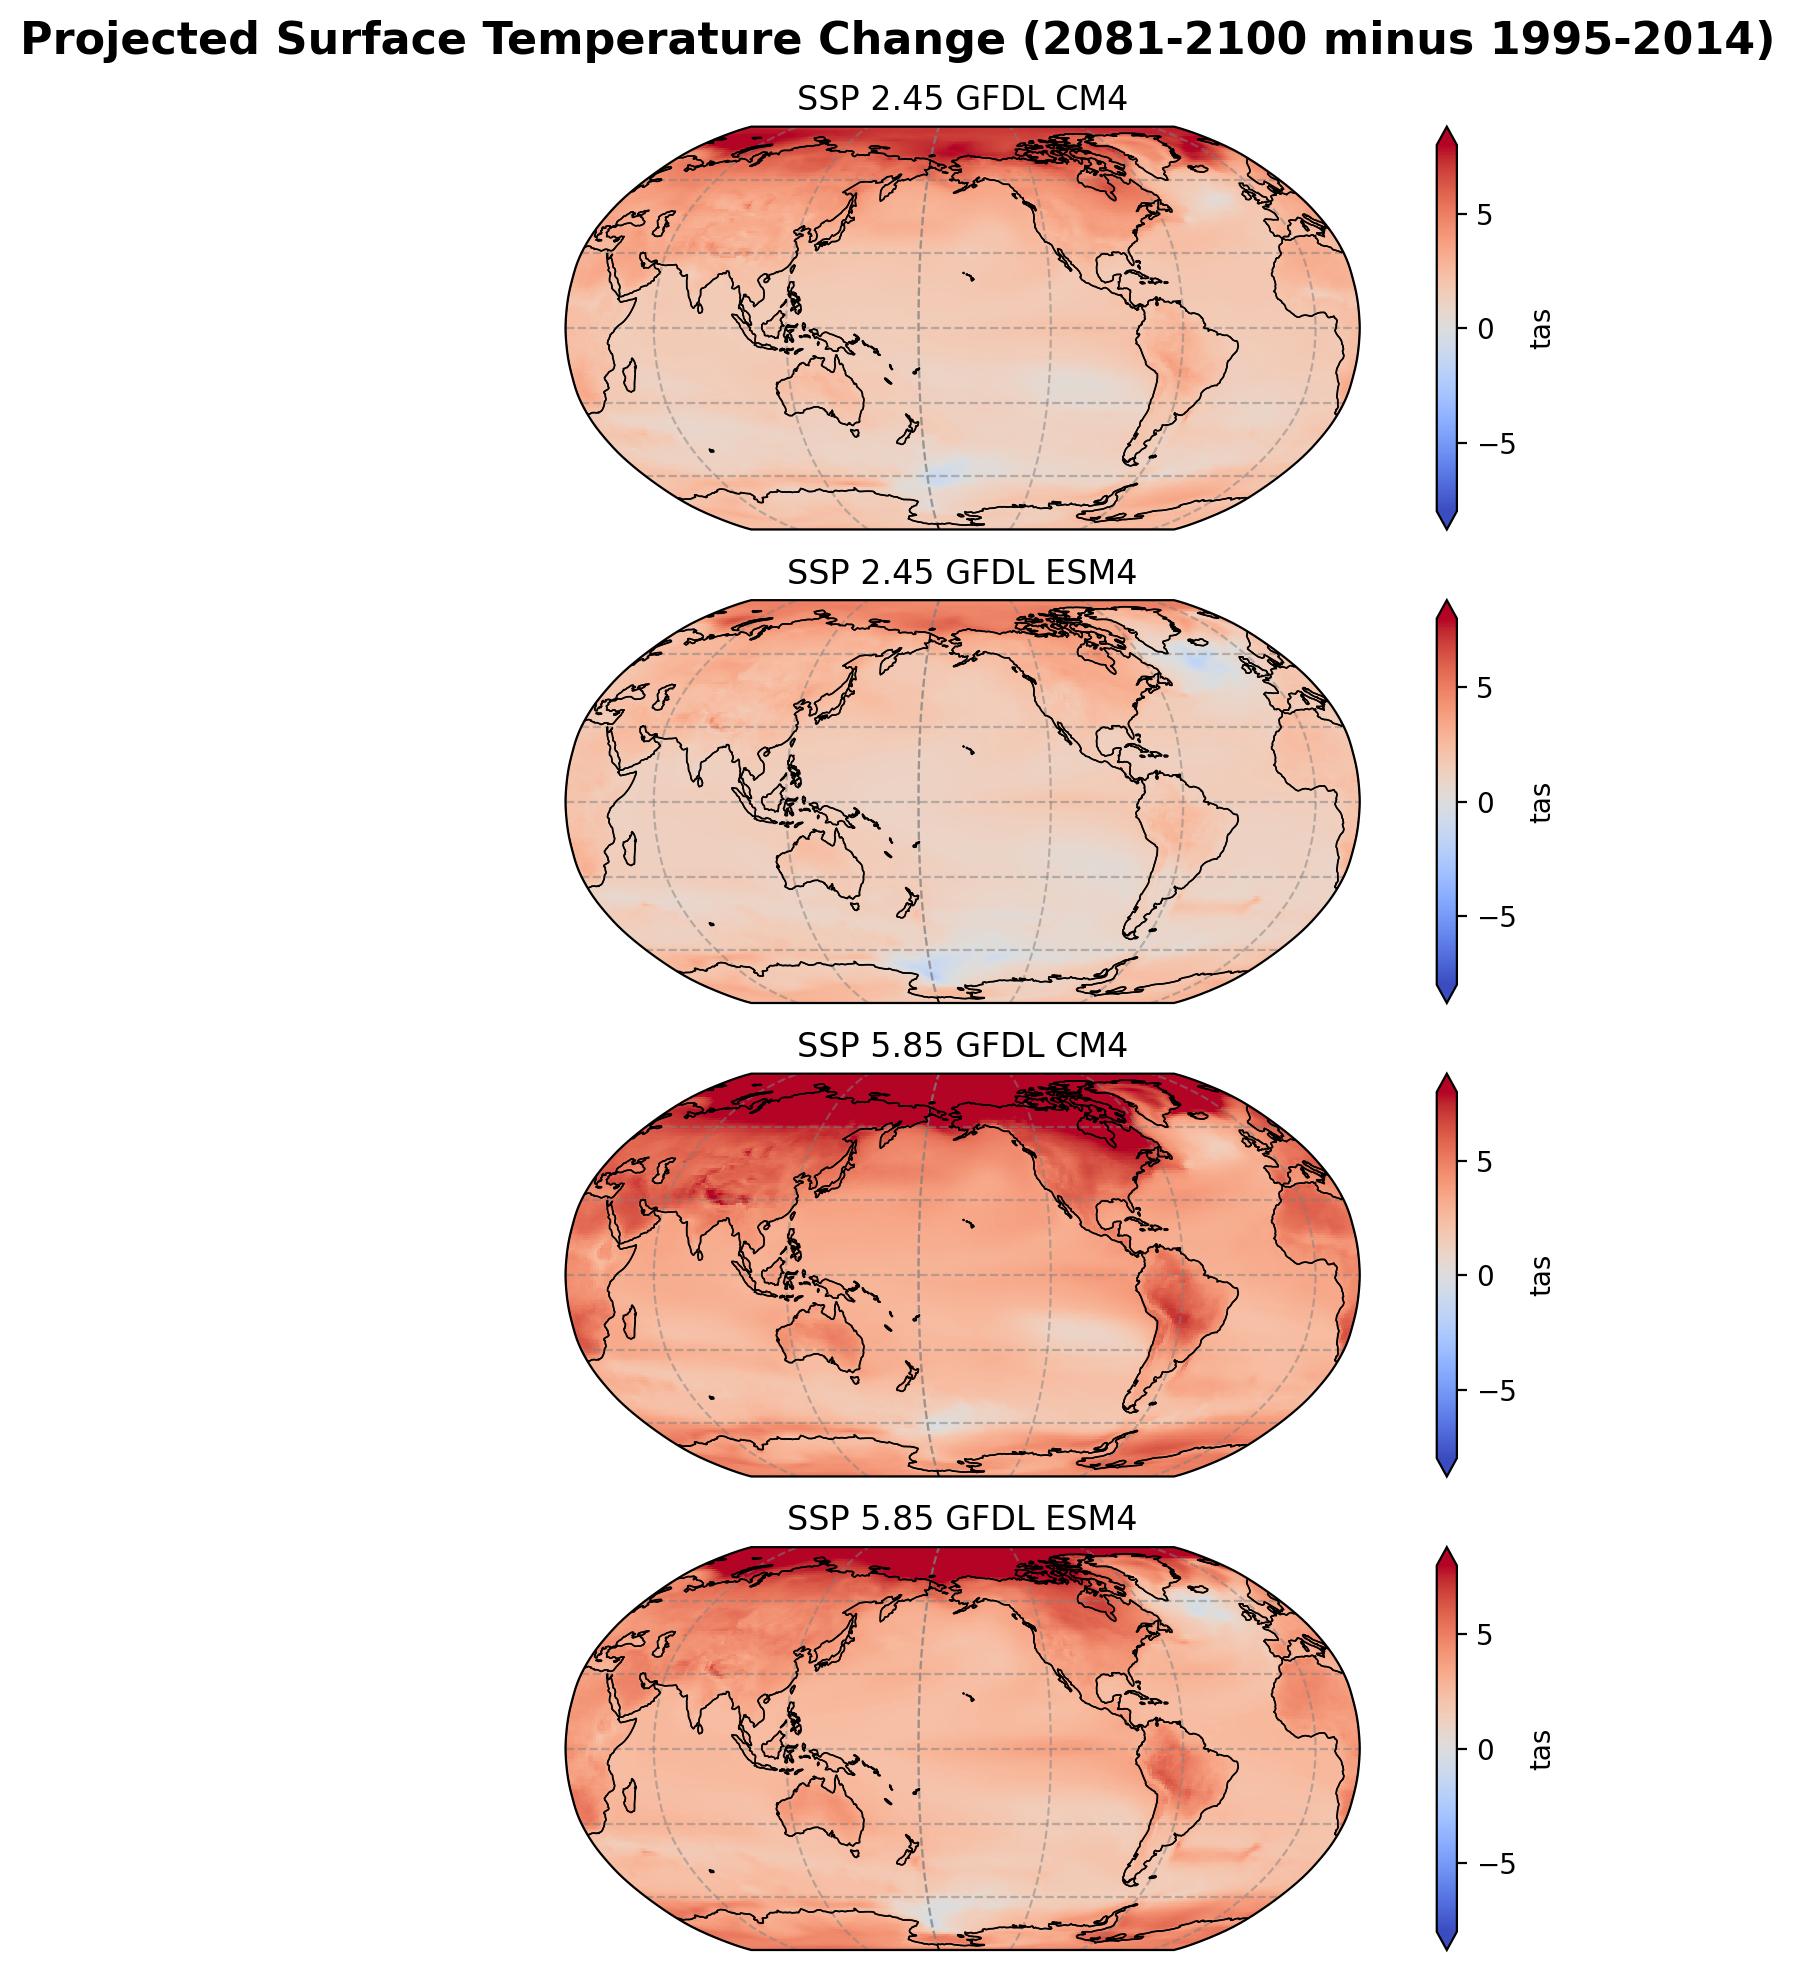

In [27]:
#Create our plots for surface temperature change from baseline - ssp585/ssp245
subplot_kws=dict(projection=ccrs.Robinson(central_longitude=-160),
                 facecolor='grey')

### set up our figure settings
fig, ax = plt.subplots(ncols=1,
                               nrows=4,
                               figsize=(8,10),
                               subplot_kw=subplot_kws) ## set up our plotting area
ax1, ax2, ax3, ax4 = ax

for ax in [ax1, ax2, ax3, ax4]:
    # Draw the actual coastlines a bit thicker
    ax.coastlines(color='black', linewidth=0.6, zorder=3)

    # explicit land polygons with outlines
    ax.add_feature(
        cfeature.LAND,
        facecolor='none',      # don't fill, just outline
        edgecolor='black',
        linewidth=0.5,
        zorder=3
    )
fig.suptitle("Projected Surface Temperature Change (2081-2100 minus 1995-2014)", 
             fontsize=16,
             fontweight='bold')

### plot our data
GFDL_CM4_diff_SSP245.plot(ax=ax1, 
                                cmap='coolwarm', 
                                vmin=-8,vmax=8, extend='both',
                                transform=ccrs.PlateCarree())

GFDL_CM4_diff_SSP585.plot(ax=ax3, 
                                cmap='coolwarm', 
                                vmin=-8,vmax=8,extend='both',
                                transform=ccrs.PlateCarree())

GFDL_ESM4_diff_SSP245.plot(ax=ax2, 
                                cmap='coolwarm', 
                                vmin=-8,vmax=8,extend='both',
                                transform=ccrs.PlateCarree())

GFDL_ESM4_diff_SSP858.plot(ax=ax4, 
                                cmap='coolwarm', 
                                vmin=-8,vmax=8,extend='both',
                                transform=ccrs.PlateCarree())
## customize our subplots
ax1.set_title('SSP 2.45 GFDL CM4')
ax2.set_title('SSP 2.45 GFDL ESM4')
ax3.set_title('SSP 5.85 GFDL CM4')
ax4.set_title('SSP 5.85 GFDL ESM4')

plt.tight_layout() ## make it look nicely spaced!

### add some gridlines 
ax1.gridlines(color='grey', alpha=0.5, linestyle='--')
ax2.gridlines(color='grey', alpha=0.5, linestyle='--')
ax3.gridlines(color='grey', alpha=0.5, linestyle='--')
ax4.gridlines(color='grey', alpha=0.5, linestyle='--')

**Figure 1 | Projected surface temperature for different emissions scenarios and models.**  
This figure shows the average projected warming from the baseline (1995-2014) to (2100-2080). This is meant to show surface temperature anomalies in the future based on 2 different SSP scenarios and comparing between two different GFDL models. Red represents warming while blue represents areas where there is cooling.

## Comparing our projected temperature changes throughout the centrury with the IPCC AR6 assessment. 
![IPCC AR6 TS Figure 1](https://www.ipcc.ch/report/ar6/wg1/downloads/figures/IPCC_AR6_WGI_TS_CCBox_1_Figure_1.png)

### In panel B the bottom global temperature map shows temperature change projected for our same time (2081-2100) but for a different SSP. We cannot directly compare but many things are analogous especially Arctic amplification which tells us we are computing similar calculations.

(IPCC 6th Assessment, 2021)

### Table 1. Projected annual-mean surface temperature anomalies

Annual-mean surface air temperature (tas) anomalies (°C) relative to the 1995–2014 baseline.
values represent the mean anomaly and  standard deviation for the near-term
(2021–2040) and long-term (2081–2100) periods.

| Model        | Scenario   | Near-term mean (°C) | Near-term SD (°C) | Long-term mean (°C) | Long-term SD (°C) |
|--------------|------------|---------------------|-------------------|---------------------|-------------------|
| GFDL-CM4     | SSP2-4.5   |        5.23         |     0.92  $\pm$  0.72           |        7.01         |   7.01 $\pm$ 19.51               |
| GFDL-CM4     | SSP5-8.5   |         5.29        |      0.97 $\pm$ 0.72             |        9.13         |   9.13 $\pm$ 19.27              |
| GFDL-ESM4    | SSP2-4.5   |        5.63         |    0.82 $\pm$  0.64               |       6.74              | 6.74 $\pm$ 19.94                      |
| GFDL-ESM4    | SSP5-8.5   |          5.59       |    0.77 $\pm$ 0.54               |          8.51           | 8.51 $\pm$ 19.51                  |

In [28]:
# The following function is used to create weights for the Earths grid space.
import warnings 

def standard_grid_cell_area(lat, lon, rE=6371.0e3):
    """ computes the cell area for a standard spherical grid """

    dLat = lat[1] - lat[0]
    dLon = lon[1] - lon[0]
    area = np.empty((len(lat), len(lon)))
    for j in range(0, len(lat)):
        for i in range(0, len(lon)):
            lon1 = lon[i] + dLon / 2
            lon0 = lon[i] - dLon / 2
            lat1 = lat[j] + dLat / 2
            lat0 = lat[j] - dLat / 2
            area[j, i] = (
                (np.pi / 180.0)
                * rE
                * rE
                * np.abs(np.sin(np.radians(lat0)) - np.sin(np.radians(lat1)))
                * np.abs(lon0 - lon1)
            )
    return area

In [29]:
gfdl_cm4_H_lat = gfdl_cm4_H_tos.coords['latitude'].values #1-D numpy array of model's latitude values
gfdl_cm4_H_lon =  gfdl_cm4_H_tos.coords['longitude'].values #1-D numpy array of model's longitude values

# make sure to replace the name of the data array if you chose a 
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.

# Pass the arrays to the standard_grid_cell_area function
areacell_gfdl_cm4_H = standard_grid_cell_area(gfdl_cm4_H_lat,gfdl_cm4_H_lon)  

# The areacella_xarray function outputs a numpy array. Convert this back into 
# and xarray DataArray for further use. If this is a field you will be using 
# often. You may wish to save this newly created DataArray as a Dataset and save 
# as a netcdf file.

# here we assign dimensions and coordinates that are the same as our original SST array:

areacell_xarray_cm4_H = xr.DataArray(areacell_gfdl_cm4_H ,dims=({'latitude':180,'longitude':360}),\
                                                coords=(gfdl_cm4_H_tos.coords['latitude'],\
                                                        gfdl_cm4_H_tos.coords['longitude']))

weights_cm4_H = areacell_xarray_cm4_H/areacell_xarray_cm4_H.sum()

In [30]:
#calculate weighted average and average over lat and longitude
wt_avg_gfdl_cm4_H= gfdl_cm4_H_tos.weighted(weights_cm4_H).mean(['latitude', 'longitude']) 
wt_avg_gfdl_ESM4_h= gfdl_ESM4_h_to.weighted(weights_cm4_H).mean(['latitude', 'longitude']) 
wt_avg_GFDl_CM4_SSP245= gfdl_cm4_24_tos.weighted(weights_cm4_H).mean(['latitude', 'longitude']) 
wt_avg_GFDl_CM4_SSP5855= gfdl_cm4_54_to.weighted(weights_cm4_H).mean(['latitude', 'longitude'])
wt_avg_GFDl_ESM4_SSP585= gfdl_esm4_tos_58.weighted(weights_cm4_H).mean(['latitude', 'longitude'])
wt_avg_GFDl_ESM4_SSP245= gfdl_esm4_tos_24.weighted(weights_cm4_H).mean(['latitude', 'longitude'])

In [31]:
# compute global annual mean and convert to celsius
gfdl_cm4_H_global_annual = wt_avg_gfdl_cm4_H.groupby("time.year").mean("time") - 273.15
gfdl_cm4_245_global_annual = wt_avg_GFDl_CM4_SSP245.groupby("time.year").mean("time") - 273.15
gfdl_cm4_585_global_annual = wt_avg_GFDl_CM4_SSP5855.groupby("time.year").mean("time") - 273.15
gfdl_esm4_H_global_annual = wt_avg_gfdl_ESM4_h.groupby("time.year").mean("time") - 273.15
gfdl_esm4_245_global_annual = wt_avg_GFDl_ESM4_SSP245.groupby("time.year").mean("time") - 273.15
gfdl_esm4_585_global_annual = wt_avg_GFDl_ESM4_SSP585.groupby("time.year").mean("time") - 273.15


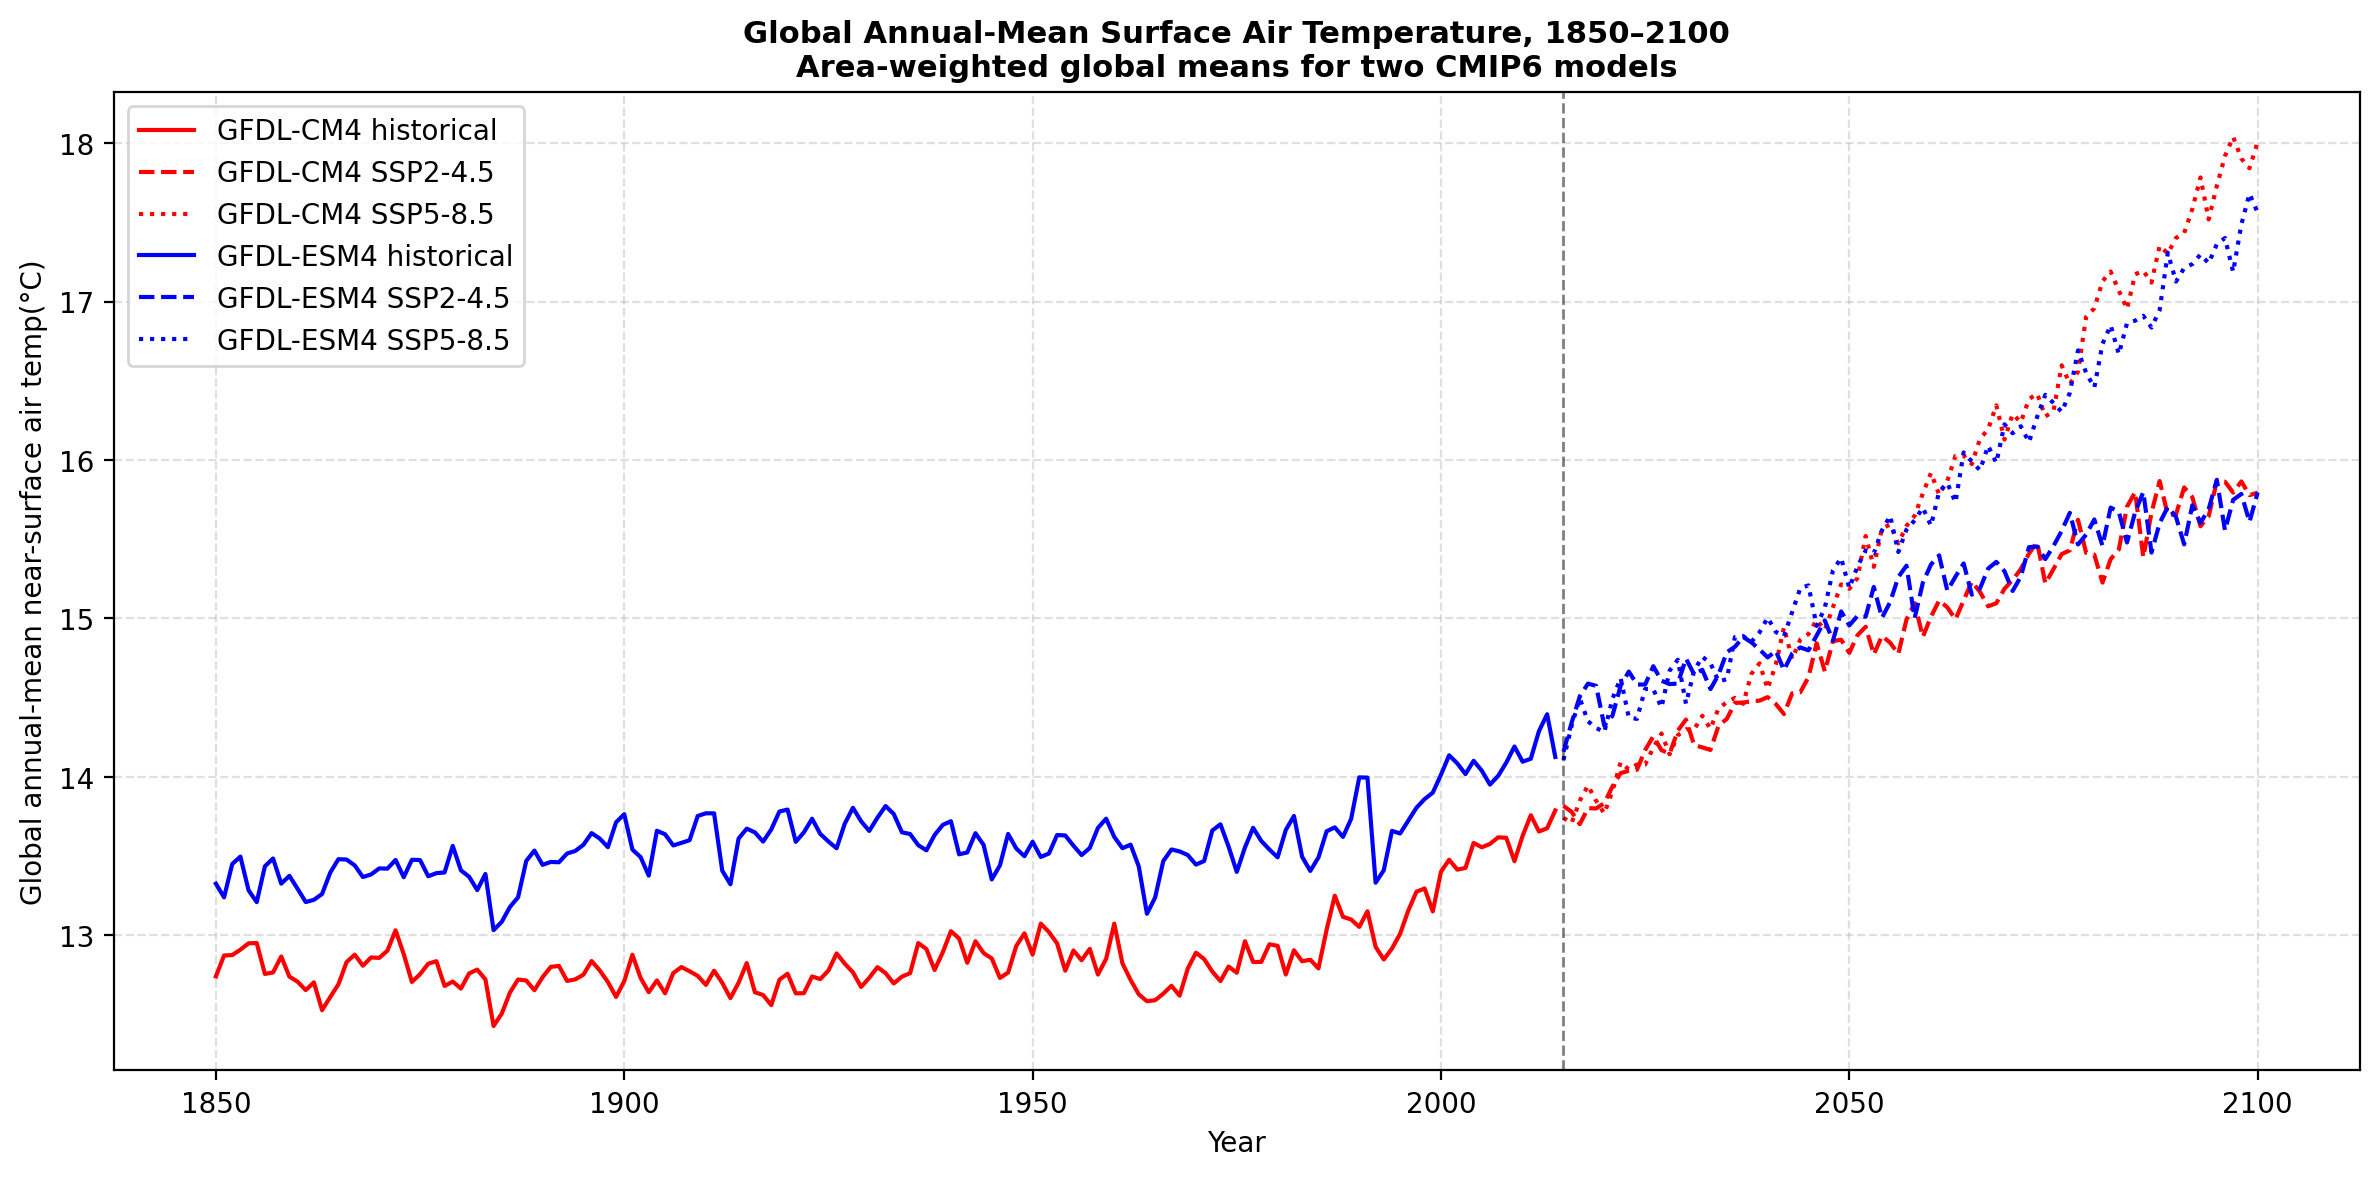

In [32]:
#Plot our globally weigheted means for all experiments
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(
    gfdl_cm4_H_global_annual["year"],
    gfdl_cm4_H_global_annual,
    color= 'red' ,
    linestyle="-",
    label="GFDL-CM4 historical"
)

ax.plot(
    gfdl_cm4_245_global_annual["year"],
    gfdl_cm4_245_global_annual,
    color= 'red' ,
    linestyle="--",
    label="GFDL-CM4 SSP2-4.5"
)

ax.plot(
   gfdl_cm4_585_global_annual["year"],
    gfdl_cm4_585_global_annual,
    color='red',
    linestyle=":",
    label="GFDL-CM4 SSP5-8.5"
)
ax.plot(
    gfdl_esm4_H_global_annual["year"],
   gfdl_esm4_H_global_annual,
    color= 'blue' ,
    linestyle="-",
    label="GFDL-ESM4 historical"
)

ax.plot(
    gfdl_esm4_245_global_annual["year"],
    gfdl_esm4_245_global_annual,
    color= 'blue' ,
    linestyle="--",
    label="GFDL-ESM4 SSP2-4.5"
)

ax.plot(
    gfdl_esm4_585_global_annual["year"],
    gfdl_esm4_585_global_annual,
    color='blue',
    linestyle=":",
    label="GFDL-ESM4 SSP5-8.5"
)

ax.set_ylabel("Global annual-mean near-surface air temp(°C)")
ax.set_xlabel("Year")
ax.set_title(
    "Global Annual-Mean Surface Air Temperature, 1850–2100\n"
    "Area-weighted global means for two CMIP6 models",
    fontsize=11,
    fontweight="bold",
    y=1
)
#Add Vertical line representing transition to scenarios
ax.axvline(2015, color="k", linewidth=1, linestyle="--", alpha=0.5)
ax.grid( linestyle="--", alpha=0.4)
ax.legend()

plt.tight_layout()
plt.show()

**Figure 2| Global Annual-Mean Surface Air Temperature From 1850-2100**
This figure shows the area-weighted global means from two different GFDL CMIP6 models. Showing temperature increases across time using the historic data as well as SSPs 2.45 and 5.85.

In [33]:
def regional_annual_mean(df, global_weights,
                         lat_min, lat_max, lon_min, lon_max):

    # 1) Slice data to the region
    array_reg = df.sel(latitude=slice(lat_min, lat_max),
                      longitude=slice(lon_min, lon_max))

    # 2) Slice weights to the same region
    wt_array = global_weights.sel(latitude=slice(lat_min, lat_max),
                               longitude=slice(lon_min, lon_max))

    # 3) Renormalize weights so they sum to 1 within the region
    wtr_array =  wt_array /  wt_array.sum()

    # 4) Area-weighted monthly regional mean
    monthly_array = array_reg.weighted(wtr_array).mean(dim=("latitude", "longitude"))

    # 5) Convert to annual mean
    annual_array = monthly_array.groupby("time.year").mean("time") - 273.15
    

    return annual_array


In [34]:
#calculate regional mean and relate it to the area we are examining
WE_regional = regional_annual_mean(gfdl_cm4_H_tos, areacell_xarray_cm4_H,
                         35, 60, -10, 30)
WE_regiona_245 = regional_annual_mean(gfdl_cm4_24_tos, areacell_xarray_cm4_H,
                         35, 60, -10, 30)
WE_regiona_585 = regional_annual_mean(gfdl_cm4_54_to, areacell_xarray_cm4_H,
                         35, 60, -10, 30)

SA_regional = regional_annual_mean(gfdl_cm4_H_tos, areacell_xarray_cm4_H,
                         5, 30, 65, 95)
SA_regional_245 = regional_annual_mean(gfdl_cm4_24_tos, areacell_xarray_cm4_H,
                         5, 30, 65, 95)
SA_regional_585 = regional_annual_mean(gfdl_cm4_54_to, areacell_xarray_cm4_H,
                         5, 30, 65, 95)

IND_regional = regional_annual_mean(gfdl_cm4_H_tos, areacell_xarray_cm4_H,
                         -10, 10, 95, 140)
IND_regional_245 = regional_annual_mean(gfdl_cm4_24_tos, areacell_xarray_cm4_H,
                         -10, 10, 95, 140)
IND_regional_585 = regional_annual_mean(gfdl_cm4_54_to, areacell_xarray_cm4_H,
                         -10, 10, 95, 140)


SSA_regional = regional_annual_mean(gfdl_cm4_H_tos, areacell_xarray_cm4_H,
                         -35, -5, -20, 52)
SSA_regional_245 = regional_annual_mean(gfdl_cm4_24_tos, areacell_xarray_cm4_H,
                         -35, -5, -20, 52)
SSA_regional_585 = regional_annual_mean(gfdl_cm4_54_to, areacell_xarray_cm4_H,
                         -35, -5, -20, 52)

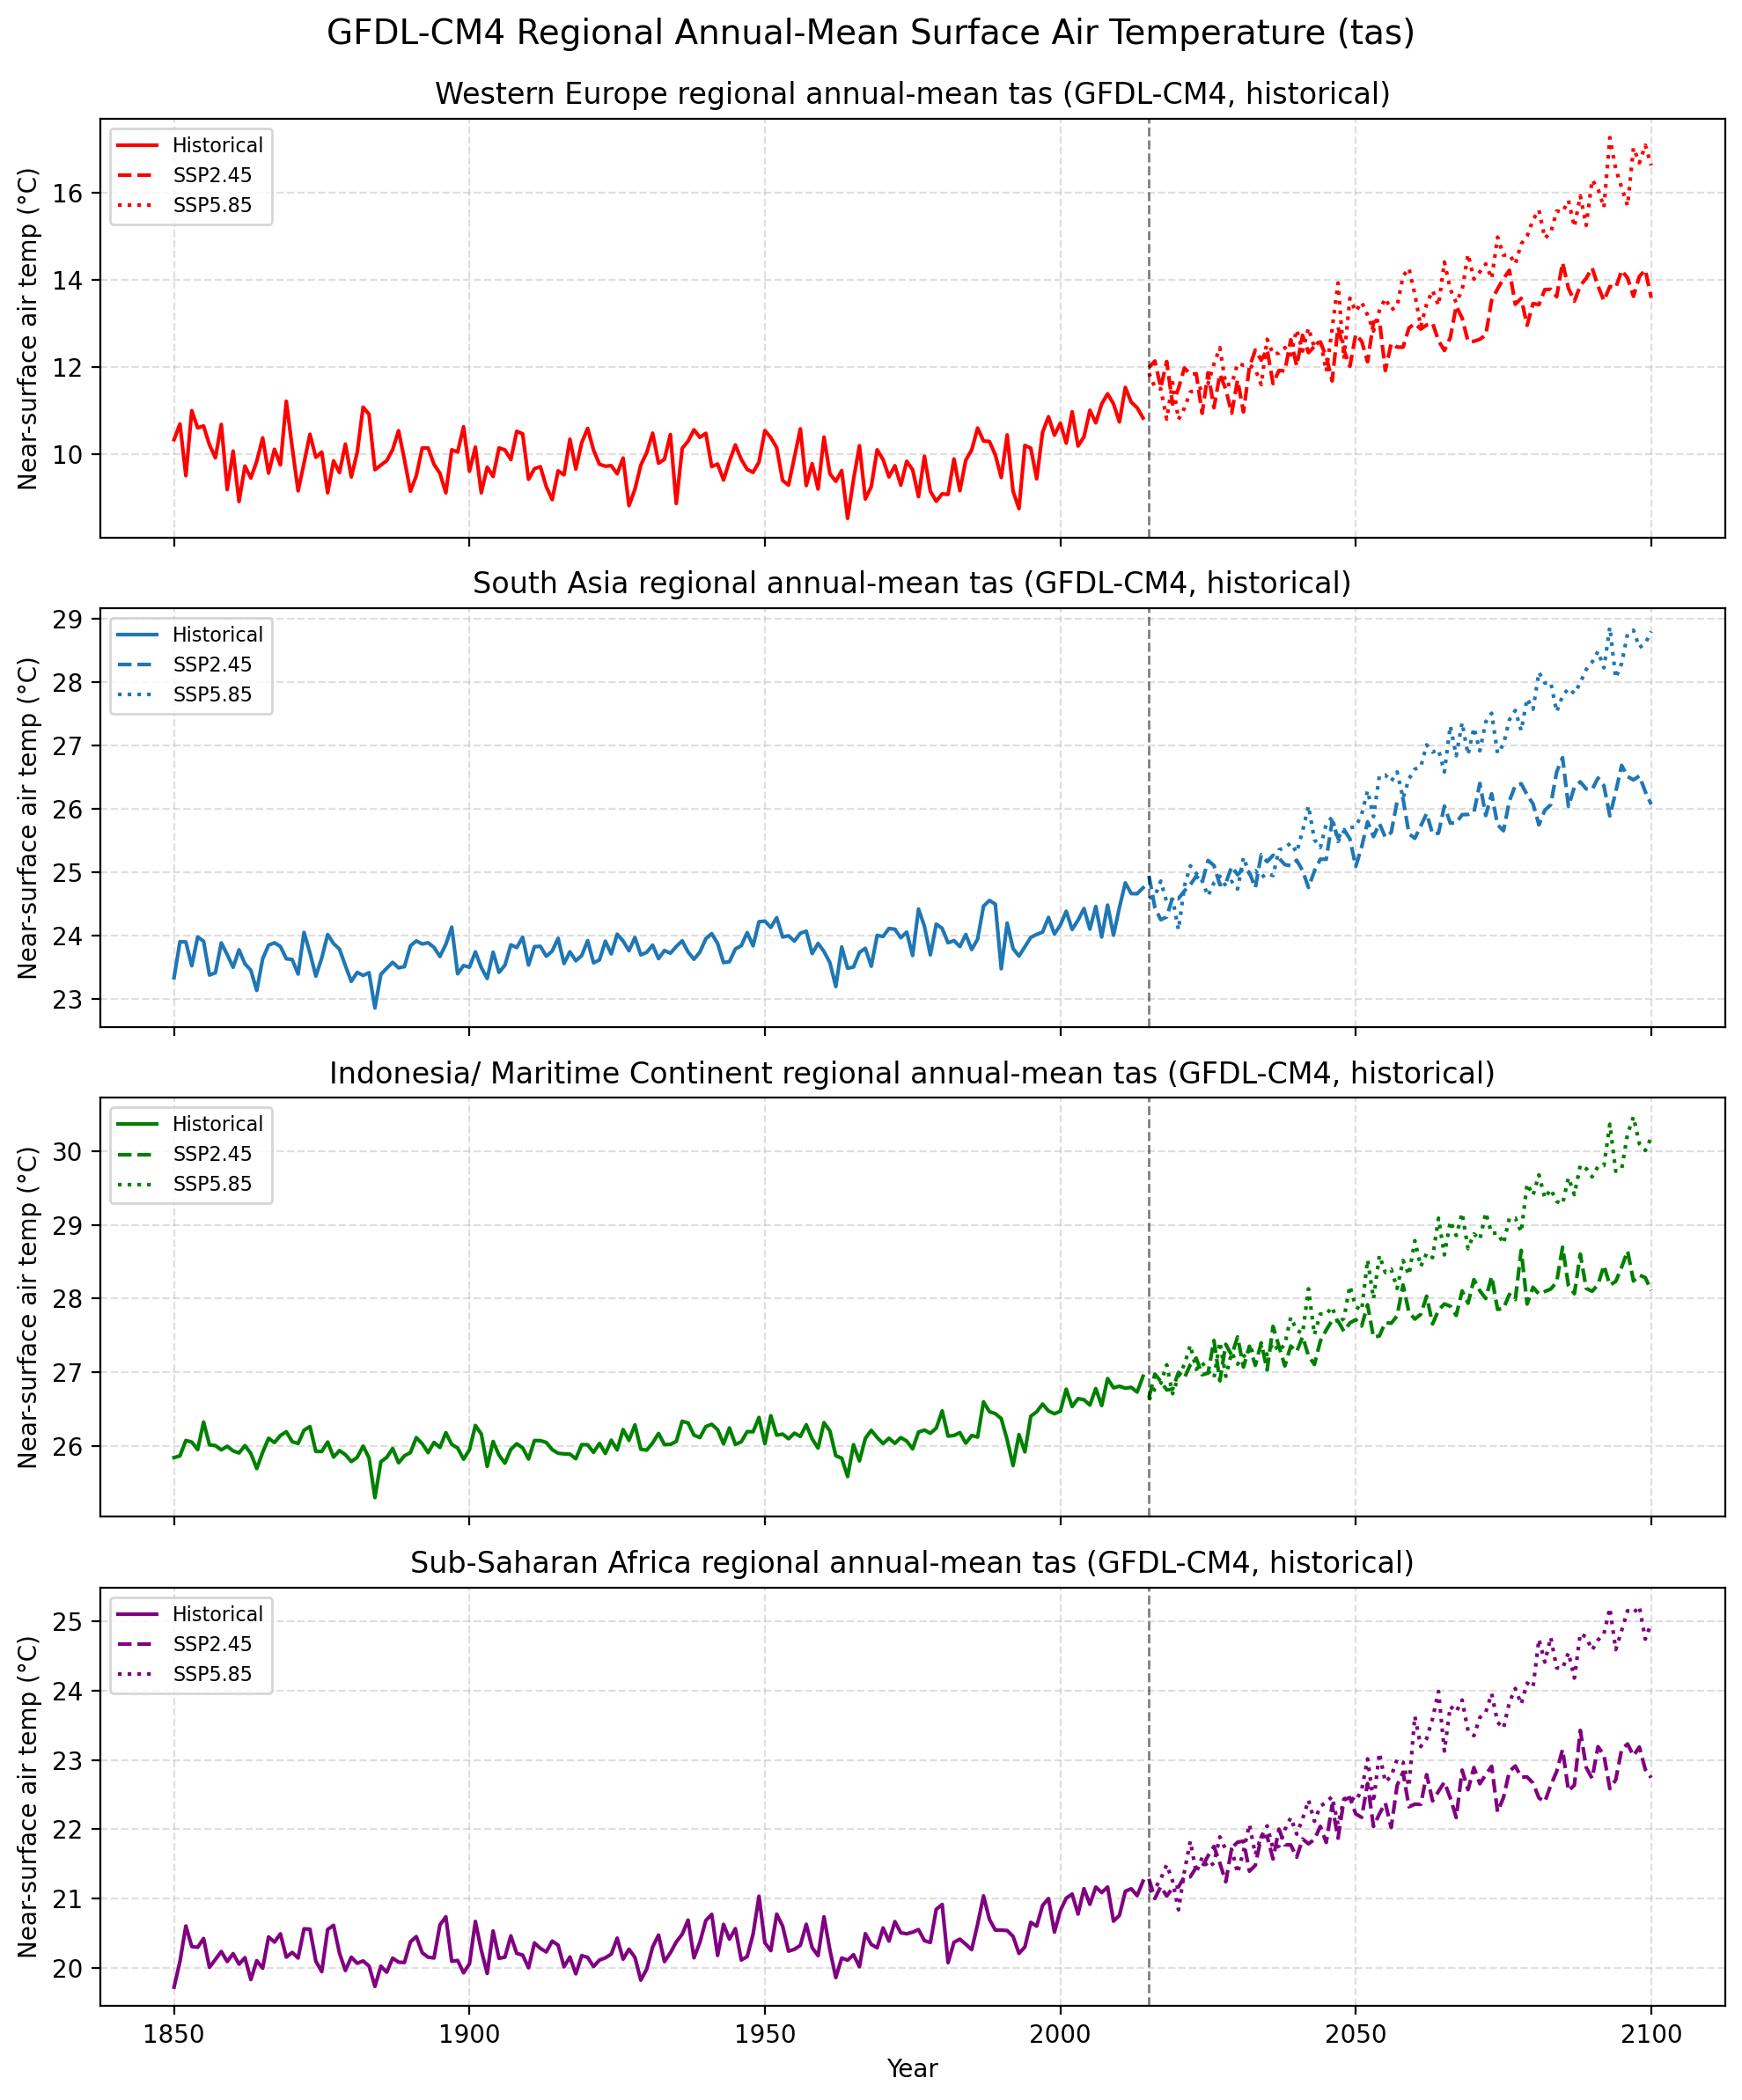

In [35]:


# Create PLot for all 4 regions
fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    nrows=4,
    ncols=1,
    figsize=(10, 12),
    sharex=True  # share the Year axis
)

#  Western Europe 
ax1.plot(
    WE_regional["year"],
    WE_regional,
    color="red",
    linestyle="-",
    label="Historical"
)

ax1.plot(
    WE_regiona_245["year"],
    WE_regiona_245,
    color="red",
    linestyle="--",
    label="SSP2.45"
)

ax1.plot(
    WE_regiona_585["year"],
    WE_regiona_585,
    color="red",
    linestyle=":",
    label="SSP5.85"
)
#Add Vertical line representing transition to scenarios
ax1.axvline(2015, color="k", linestyle="--", linewidth=1, alpha=0.5)
ax1.set_ylabel("Near-surface air temp (°C)")
ax1.set_title("Western Europe regional annual-mean tas (GFDL-CM4, historical)")
ax1.grid( linestyle="--", alpha=0.4)
ax1.legend(loc="upper left", fontsize=8)

#  South Asia 

ax2.plot(
    SA_regional["year"],
    SA_regional,
    color="tab:blue",
    linestyle="-",
    label="Historical"
)

ax2.plot(
    SA_regional_245["year"],
    SA_regional_245,
    color="tab:blue",
    linestyle="--",
    label="SSP2.45"
)

ax2.plot(
    SA_regional_585["year"],
    SA_regional_585,
    color="tab:blue",
    linestyle=":",
    label="SSP5.85"
)
#Add Vertical line representing transition to scenarios
ax2.axvline(2015, color="k", linestyle="--", linewidth=1, alpha=0.5)
ax2.set_ylabel("Near-surface air temp (°C)")
ax2.set_title("South Asia regional annual-mean tas (GFDL-CM4, historical)")
ax2.grid( linestyle="--", alpha=0.4)
ax2.legend(loc="upper left", fontsize=8)

#  Indonesia 

ax3.plot(
    IND_regional["year"],
    IND_regional,
    color="green",
    linestyle="-",
    label="Historical"
)

ax3.plot(
    IND_regional_245["year"],
    IND_regional_245,
    color="green",
    linestyle="--",
    label="SSP2.45"
)

ax3.plot(
    IND_regional_585["year"],
    IND_regional_585,
    color="green",
    linestyle=":",
    label="SSP5.85"
)
#Add Vertical line representing transition to scenarios
ax3.axvline(2015, color="k", linestyle="--", linewidth=1, alpha=0.5)
ax3.set_ylabel("Near-surface air temp (°C)")
ax3.set_title("Indonesia/ Maritime Continent regional annual-mean tas (GFDL-CM4, historical)")
ax3.grid( linestyle="--", alpha=0.4)
ax3.legend(loc="upper left", fontsize=8)

#  Sub-Saharan Africa 

ax4.plot(
    SSA_regional["year"],
    SSA_regional,
    color="purple",
    linestyle="-",
    label="Historical"
)

ax4.plot(
    SSA_regional_245["year"],
    SSA_regional_245,
    color="purple",
    linestyle="--",
    label="SSP2.45"
)

ax4.plot(
    SSA_regional_585["year"],
    SSA_regional_585,
    color="purple",
    linestyle=":",
    label="SSP5.85"
)

ax4.set_ylabel("Near-surface air temp (°C)")
ax4.set_xlabel("Year")
ax4.set_title("Sub-Saharan Africa regional annual-mean tas (GFDL-CM4, historical)")
ax4.grid( linestyle="--", alpha=0.4)
ax4.legend(loc="upper left", fontsize=8)
#Add Vertical line representing transition to scenarios
ax4.axvline(2015, color="k", linestyle="--", linewidth=1, alpha=0.5)
# title for the whole figure
fig.suptitle(
    "GFDL-CM4 Regional Annual-Mean Surface Air Temperature (tas)",
    fontsize=14,
    y=0.99
)

plt.tight_layout()
plt.show()

**Figure 3| Regionally weighted annual-mean temperature timeseries for 4 different regions**
Different panels use the same regional weighting technique. Temperature is measured from the historical data, and each includes continued future projections based on SSP 2.45 and SSP 5.85. There is also a line in 2014 to represent the beginning of scenario data.

## Comparing our Regional Findings with the IPCC
![IPCC AR6 TS 7 ](https://www.ipcc.ch/report/ar6/wg1/downloads/figures/IPCC_AR6_WGI_TS_Figure_7.png)

### There are many different regions on this graph, but when we look at the regions used for this project, we can see warming patterns that are analogous with the IPCC findings.
(IPCC 6th Assessment, 2021)

In [36]:
# Create seperate land and ocean weights
land_frac = gfdl_ESM4_h_fx/100
ocean_frac = 1.0- land_frac

#create Global area weights from previous weighted calculation
weights_cm4_H 

#create land and ocean weights
weights_land = weights_cm4_H  * land_frac
weights_ocean = weights_cm4_H * ocean_frac

#Renormalize
weights_land = weights_land/weights_land.sum()
weights_ocean = weights_ocean/weights_ocean.sum()


In [37]:
#create a function to help us compute the weighted annual mean
def weighted_annual_mean(tas, weights):
    """
    tas: DataArray(time, lat, lon)
    weights: DataArray(lat, lon) that sums to 1
    """
    monthly = tas.weighted(weights).mean(("latitude", "longitude"))
    annual = monthly.groupby("time.year").mean("time") - 273.15
    return annual


In [38]:
#Historic experiments for Land and Ocean
land_gfdl_CM4_H = weighted_annual_mean(gfdl_cm4_H_tos, weights_land)
ocean_gfdl_CM4_H = weighted_annual_mean(gfdl_cm4_H_tos, weights_ocean)
land_gfdl_ESM4_H = weighted_annual_mean(gfdl_ESM4_h_to, weights_land)
ocean_gfdl_ESM4_H =weighted_annual_mean(gfdl_ESM4_h_to, weights_ocean)

# SSP245 experiments for Land and Ocean
land_gfdl_CM4_245 = weighted_annual_mean(gfdl_cm4_24_tos, weights_land)
ocean_gfdl_CM4_245 = weighted_annual_mean(gfdl_cm4_24_tos, weights_ocean)
land_gfdl_ESM4_245 = weighted_annual_mean(gfdl_esm4_tos_24, weights_land)
ocean_gfdl_ESM4_245 =weighted_annual_mean(gfdl_esm4_tos_24, weights_ocean)

#SSP585 experiments for Land and Ocean

land_gfdl_CM4_585 = weighted_annual_mean(gfdl_cm4_54_to, weights_land)
ocean_gfdl_CM4_585 = weighted_annual_mean(gfdl_cm4_54_to, weights_ocean)
land_gfdl_ESM4_585 = weighted_annual_mean(gfdl_esm4_tos_58, weights_land)
ocean_gfdl_ESM4_585 =weighted_annual_mean(gfdl_esm4_tos_58, weights_ocean)

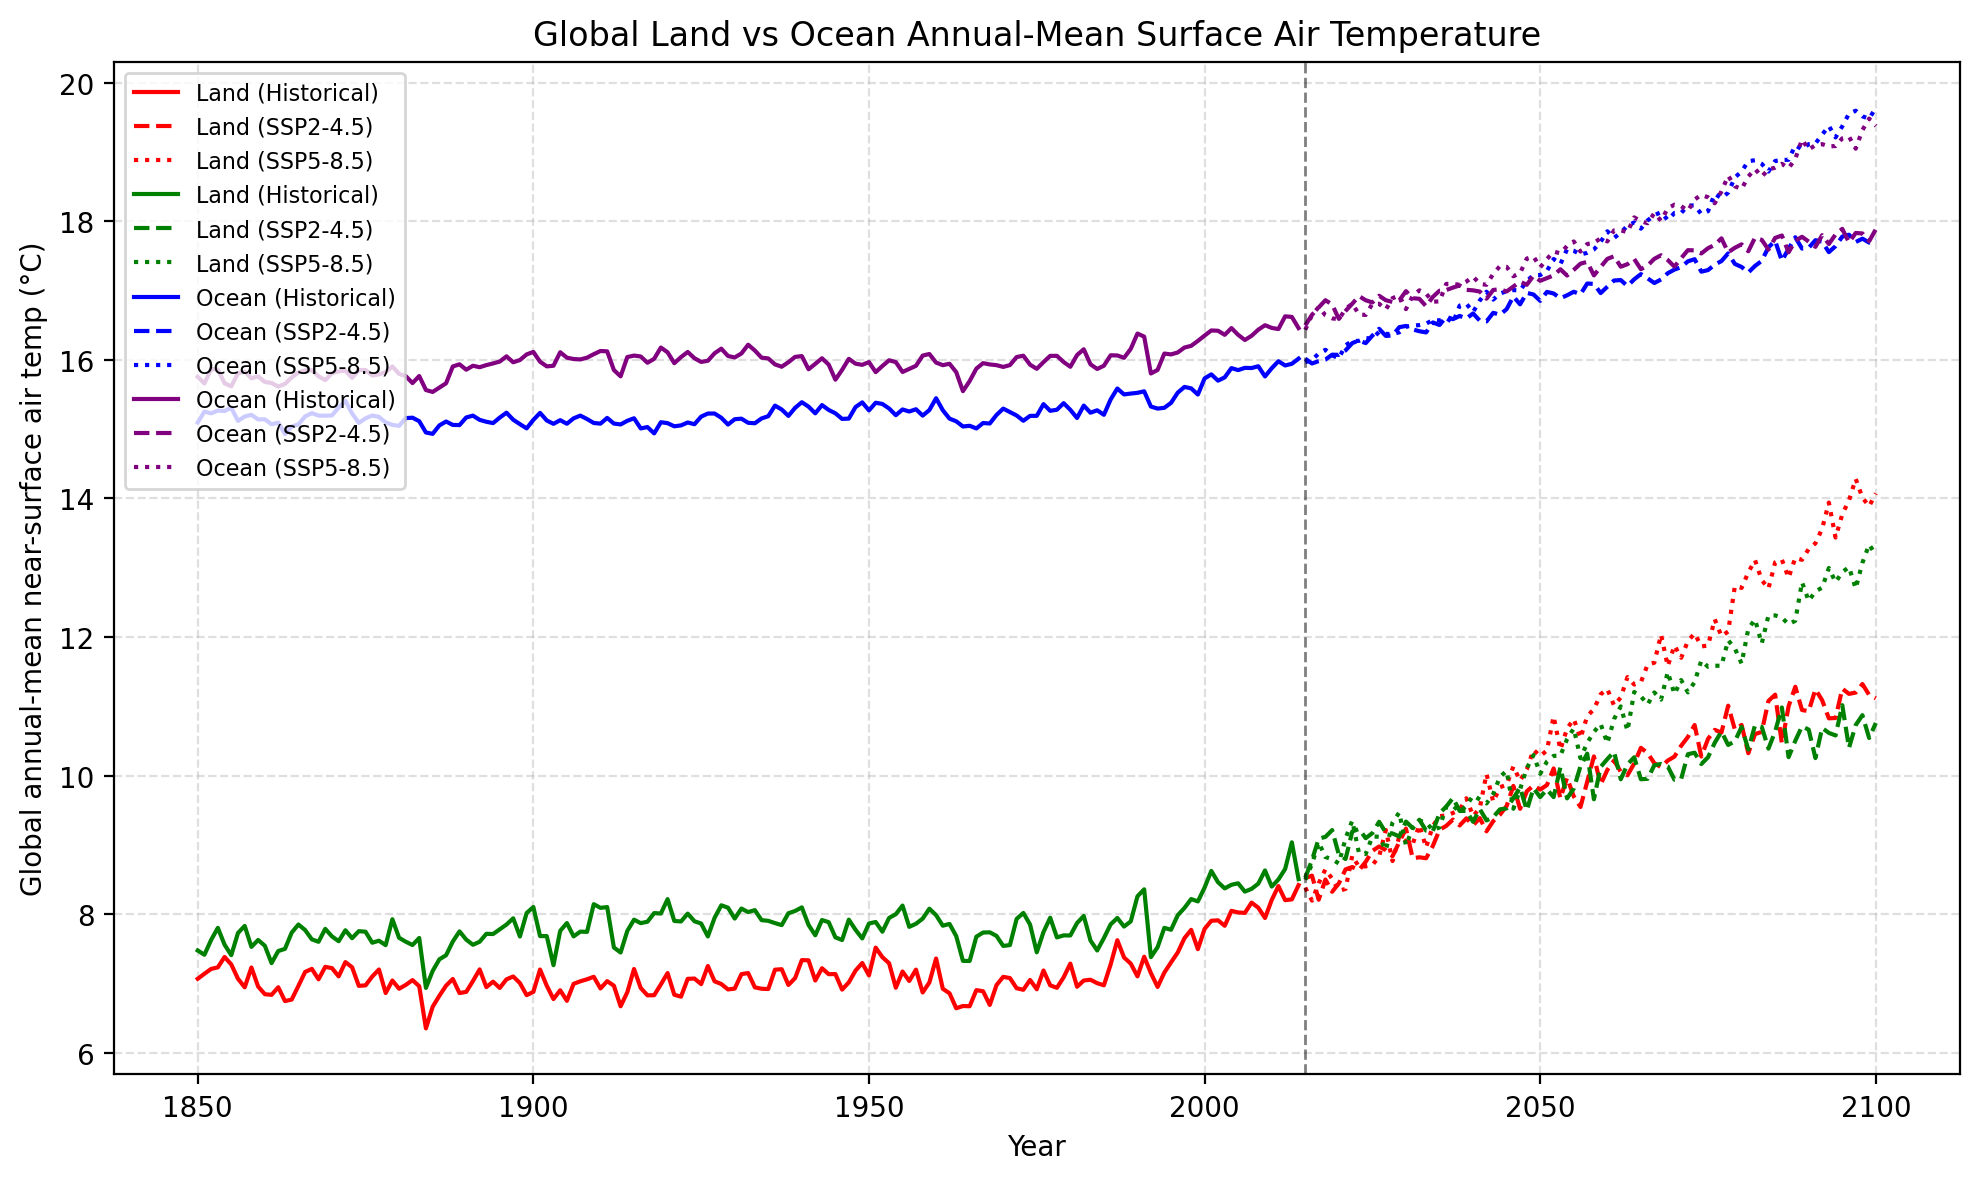

In [39]:
#create land and ocean plot
fig, ax = plt.subplots(figsize=(10, 6))

# Land Experiments
ax.plot(land_gfdl_CM4_H["year"], land_gfdl_CM4_H, color="red",  linestyle="-",  label="Land (Historical)")
ax.plot(land_gfdl_CM4_245["year"], land_gfdl_CM4_245, color="red",  linestyle="--", label="Land (SSP2-4.5)")
ax.plot(land_gfdl_CM4_585["year"], land_gfdl_CM4_585, color="red",  linestyle=":",  label="Land (SSP5-8.5)")
ax.plot(land_gfdl_ESM4_H["year"], land_gfdl_ESM4_H, color="green",  linestyle="-",  label="Land (Historical)")
ax.plot(land_gfdl_ESM4_245["year"], land_gfdl_ESM4_245, color="green",  linestyle="--", label="Land (SSP2-4.5)")
ax.plot(land_gfdl_ESM4_585 ["year"], land_gfdl_ESM4_585, color="green",  linestyle=":",  label="Land (SSP5-8.5)")

# Ocean Experiments
ax.plot(ocean_gfdl_CM4_H["year"],ocean_gfdl_CM4_H, color="blue", linestyle="-",  label="Ocean (Historical)")
ax.plot(ocean_gfdl_CM4_245["year"], ocean_gfdl_CM4_245, color="blue", linestyle="--", label="Ocean (SSP2-4.5)")
ax.plot(ocean_gfdl_CM4_585["year"], ocean_gfdl_CM4_585, color="blue", linestyle=":",  label="Ocean (SSP5-8.5)")
ax.plot(ocean_gfdl_ESM4_H["year"], ocean_gfdl_ESM4_H, color="purple", linestyle="-",  label="Ocean (Historical)")
ax.plot(ocean_gfdl_ESM4_245["year"], ocean_gfdl_ESM4_245, color="purple", linestyle="--", label="Ocean (SSP2-4.5)")
ax.plot(ocean_gfdl_ESM4_585["year"], ocean_gfdl_ESM4_585, color="purple", linestyle=":",  label="Ocean (SSP5-8.5)")
# Format
ax.set_xlabel("Year")
ax.set_ylabel("Global annual-mean near-surface air temp (°C)")
ax.set_title("Global Land vs Ocean Annual-Mean Surface Air Temperature")

ax.axvline(2015, color="k", linestyle="--", linewidth=1, alpha=0.5)
ax.grid( linestyle="--", alpha=0.4)

ax.legend(loc="upper left", fontsize=8)

plt.tight_layout()
plt.show()


**Figure 4| Global land vs Ocean Annual-Mean Surface Air Temperature**
This figure shows historical and predicted temperature (from 2 different SSPs) across land and ocean from 2 different GFDL models. Using weights for land and ocean respectively.  


In [40]:
#Compute Difference using our previous variables and get the zonal means (lon) 
zonal_cm4_245 = GFDL_CM4_diff_SSP245.mean("longitude")
zonal_cm4_585 = GFDL_CM4_diff_SSP585.mean("longitude")
zonal_esm4_245 = GFDL_ESM4_diff_SSP858.mean("longitude")
zonal_esm4_585 = GFDL_ESM4_diff_SSP245.mean("longitude")

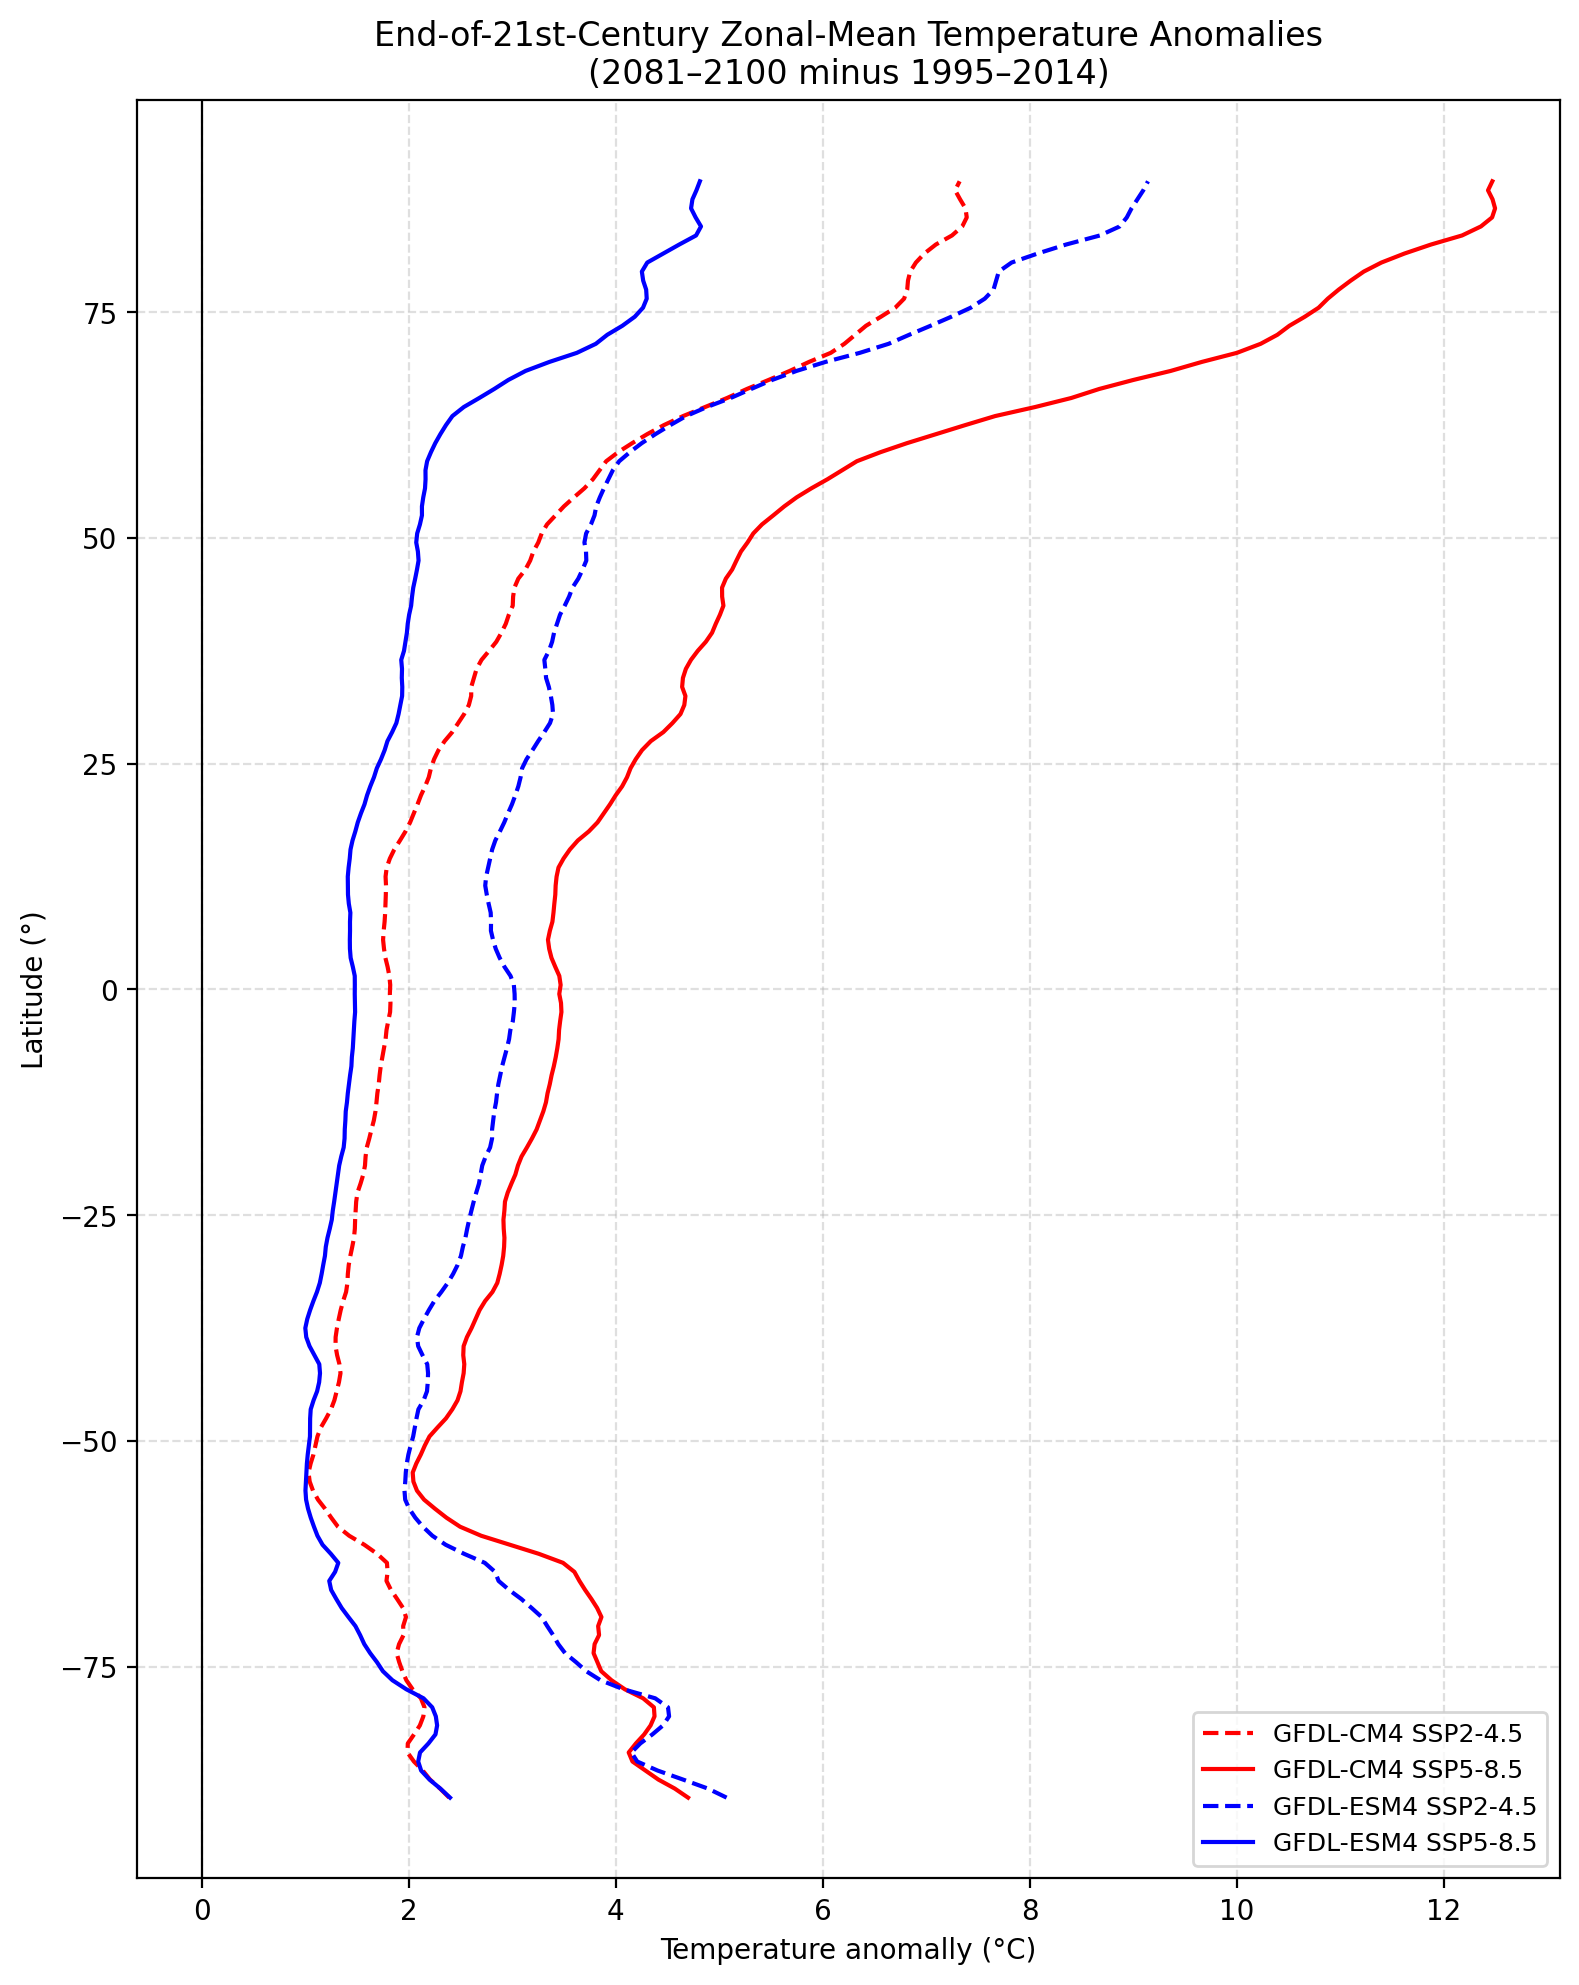

In [41]:
#plot our Zonal mean temp anomalies
fig, ax = plt.subplots(figsize=(8, 10))

#  GFDL-CM4 
ax.plot(
    zonal_cm4_245,
    zonal_cm4_245["latitude"],
    color="red",
    linestyle="--",
    label="GFDL-CM4 SSP2-4.5"
)

ax.plot(
    zonal_cm4_585,
    zonal_cm4_585["latitude"],
    color="red",
    linestyle="-",
    label="GFDL-CM4 SSP5-8.5"
)

# GFDL-ESM4
ax.plot(
    zonal_esm4_245,
    zonal_esm4_245["latitude"],
    color="blue",
    linestyle="--",
    label="GFDL-ESM4 SSP2-4.5"
)

ax.plot(
    zonal_esm4_585,
    zonal_esm4_585["latitude"],
    color="blue",
    linestyle="-",
    label="GFDL-ESM4 SSP5-8.5"
)

# Format
ax.axvline(0, color="k", linewidth=0.8)
ax.set_xlabel("Temperature anomally (°C)")
ax.set_ylabel("Latitude (°)")
ax.set_title(
    "End-of-21st-Century Zonal-Mean Temperature Anomalies\n"
    "(2081–2100 minus 1995–2014)"
)

ax.grid(linestyle="--", alpha=0.4)
ax.legend(fontsize=9)

plt.tight_layout()
plt.show()


**Figure 5| End of century zonal-mean warming**
Zonal-mean surface air temperature anomalies in degree Celsius for 2081-2100 relative to 1995-2015 as a function of latitude. Results are shown for SSP2-4.5 and SSP5-8.5 for each model. 

## Comparing the zonal mean we found in our data with the zonal mean from the IPCC 6th assesment 
![IPCC TS Figure 3](https://www.ipcc.ch/report/ar6/wg1/downloads/figures/IPCC_AR6_WGI_TS_Figure_3.png)

### In our zonal mean figure, for temperature over different latitudes, we can see that there are similarities especially near the 0-degree bound. Then once we get into the upper latitudes temperature continues to increase this is heavily related to Arctic amplification and this is analogous in both figures. 

(IPCC 6th Assessment, 2021)

In [42]:
#Create Baseline and future prediction slice
GFDL_CM4_baseline_zonal = gfdl_cm4_H_tos.sel(time=slice('1995-01-06','2014-12-16')).groupby("time.month").mean(dim="time")

GFDL_ESM4_baseline_zonal = gfdl_ESM4_h_to.sel(time=slice('1994-01-06','2014-12-16')).groupby("time.month").mean(dim="time")

GFDl_CM4_SSP245_zonal = gfdl_cm4_24_tos.sel(time=slice('2081-01-16','2100-12-16')).groupby("time.month")

GFDl_CM4_SSP585_zonal = gfdl_cm4_54_to.sel(time=slice('2081-01-16','2100-12-16')).groupby("time.month")

GFDl_ESM4_SSP585_zonal = gfdl_esm4_tos_58.sel(time=slice('2081-01-16','2100-12-16')).groupby("time.month")

GFDl_ESM4_SSP245_zonal = gfdl_esm4_tos_24.sel(time=slice('2081-01-16','2100-12-16')).groupby("time.month")

In [43]:
# average over our lattitude dimension 
Zonal_anom_SSP245_CM4 = (GFDl_CM4_SSP245_zonal - GFDL_CM4_baseline_zonal).mean("latitude")
Zonal_anom_SSP585_CM4 = (GFDl_CM4_SSP585_zonal - GFDL_CM4_baseline_zonal).mean("latitude")
Zonal_anom_SSP245_ESM4 = (GFDl_ESM4_SSP245_zonal - GFDL_CM4_baseline_zonal).mean("latitude")
Zonal_anom_SSP585_ESM4 = (GFDl_ESM4_SSP585_zonal - GFDL_CM4_baseline_zonal).mean("latitude")

C:\ProgramData\miniconda3\envs\climate\Lib\site-packages\xarray\core\indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 20 times more chunks
  return self.array[key]
C:\ProgramData\miniconda3\envs\climate\Lib\site-packages\xarray\core\indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 20 times more chunks
  return self.array[key]
C:\ProgramData\miniconda3\envs\climate\Lib\site-packages\xarray\core\indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 20 times more chunks
  return self.array[key]
C:\ProgramData\miniconda3\envs\climate\Lib\site-packages\xarray\core\indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 20 times more chunks
  return self.array[key]


In [44]:
# average over our longitude 
Zonal_Lat_time_cm4_245 = Zonal_anom_SSP245_CM4.mean("longitude") 
Zonal_Lat_time_cm4_585 = Zonal_anom_SSP585_CM4.mean("longitude")  
Zonal_Lat_time_esm4_245 = Zonal_anom_SSP245_ESM4.mean("longitude")  
Zonal_Lat_time_esm4_585 = Zonal_anom_SSP585_ESM4.mean("longitude") 

In [45]:
# average over our time dimension 
Zonal_Lat_time_cm4_245 = Zonal_Lat_time_cm4_245.groupby("time.year").mean("time") 
Zonal_Lat_time_cm4_585 = Zonal_Lat_time_cm4_585.groupby("time.year").mean("time")
Zonal_Lat_time_esm4_245 = Zonal_Lat_time_esm4_245.groupby("time.year").mean("time")
Zonal_Lat_time_esm4_585 = Zonal_Lat_time_esm4_585.groupby("time.year").mean("time")

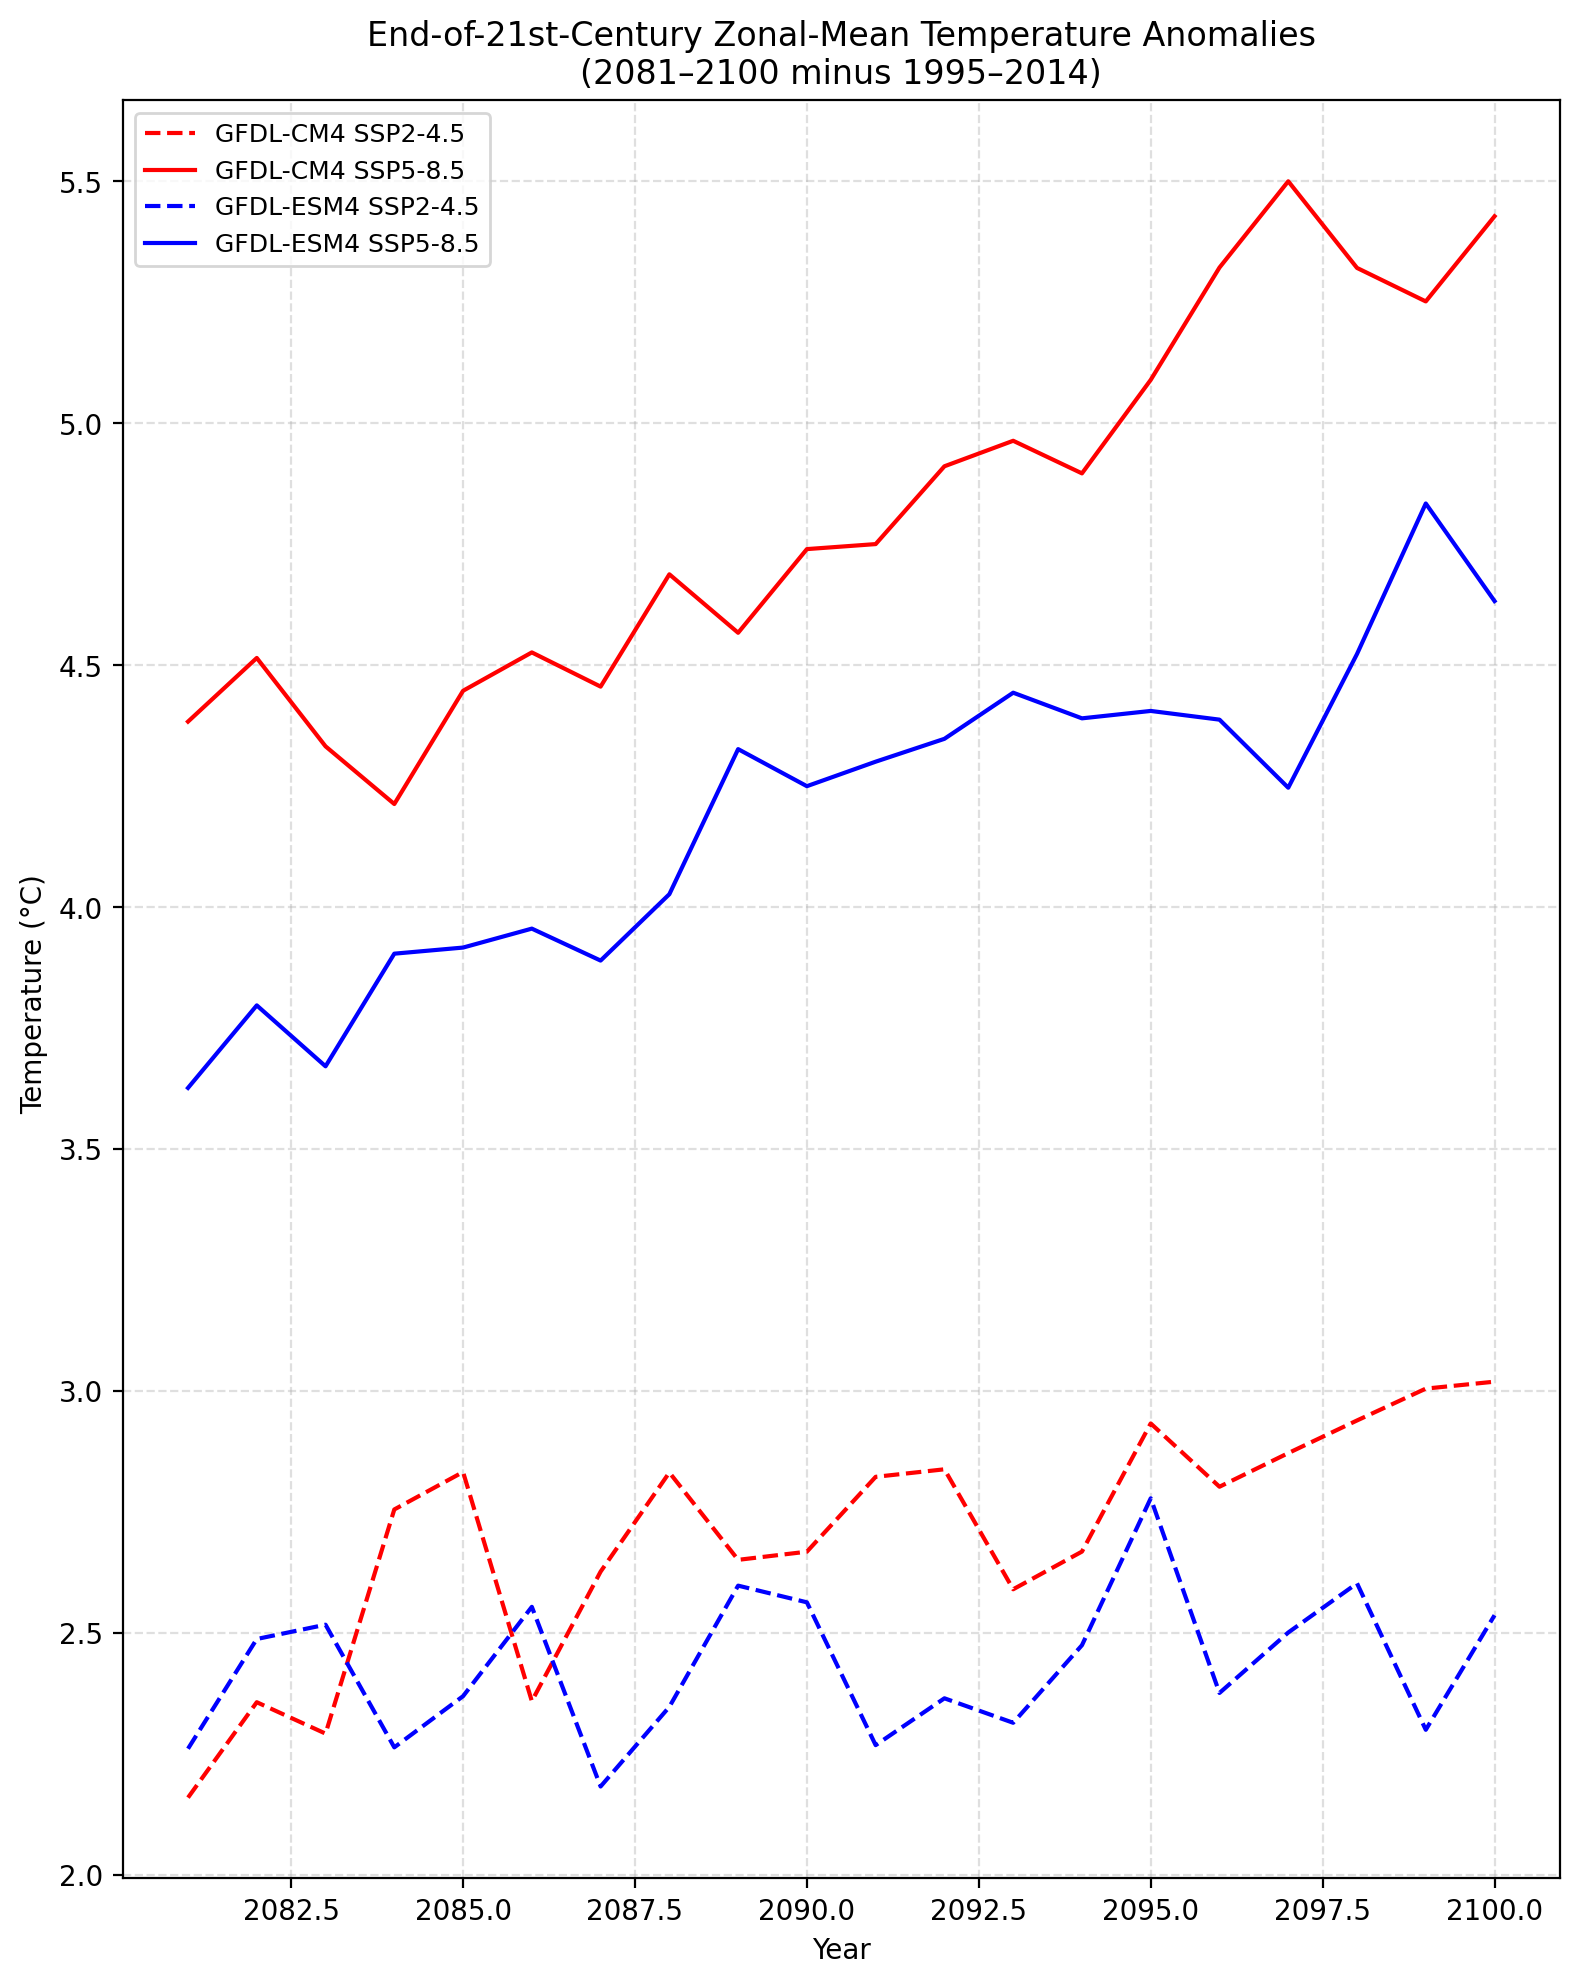

In [46]:
fig, ax = plt.subplots(figsize=(8, 10))

#  GFDL-CM4 
ax.plot(
    Zonal_Lat_time_cm4_245["year"],
    Zonal_Lat_time_cm4_245,
    color="red",
    linestyle="--",
    label="GFDL-CM4 SSP2-4.5"
)


ax.plot(
    Zonal_Lat_time_cm4_585["year"],
    Zonal_Lat_time_cm4_585,
    color="red",
    linestyle="-",
    label="GFDL-CM4 SSP5-8.5"
)


# GFDL-ESM4

ax.plot(
    Zonal_Lat_time_esm4_245["year"],
    Zonal_Lat_time_esm4_245,
    color="blue",
    linestyle="--",
    label="GFDL-ESM4 SSP2-4.5"
)

ax.plot(
    Zonal_Lat_time_esm4_585["year"],
    Zonal_Lat_time_esm4_585,
    color="blue",
    linestyle="-",
    label="GFDL-ESM4 SSP5-8.5"
)


# Format

ax.set_xlabel("Year")
ax.set_ylabel("Temperature (°C) ")
ax.set_title(
    "End-of-21st-Century Zonal-Mean Temperature Anomalies\n"
    "(2081–2100 minus 1995–2014)"
)

ax.grid(linestyle="--", alpha=0.4)
ax.legend(fontsize=9)

plt.tight_layout()
plt.show()


**Figure 6| Latitude-time Zonal-mean Projections**
Zonal-mean temperature anomalies in degrees Celsius as a function of latitude and time(2081-2100). Anomalies are computed relative to the 1995-2014 baseline and shown separately  for each model and scenario. 

## Section 2 using TA data from CMIP 6
### In this section we use atmospheric temperature on pressure levels. 
- Figure 7: Vertical profile of temperature change show widespread tropospheric warming across models, this is accompanied by cooling in the stratosphere. This pattern is consistent with increased greenhouse gas concentrations.
- Figure 8: Vertical profiles of temperature change show tropospheric warming in all models and cooling in the stratosphere again but this time with vertical profiles. We see similar warming across models, but it is significantlytintensifiedied especially in the center of the stratosphere, for SSP5-8.5. especially in the center of the stratosphere, for SSP5-8.5.

(IPCC 6th Assessment, 2021)

In [47]:
#create global weights for pressure data
gfdl_cm4_H_tao_lat = gfdl_cm4_H_tao.coords['latitude'].values #1-D numpy array of model's latitude values
gfdl_cm4_H_tao_lon =  gfdl_cm4_H_tao.coords['longitude'].values #1-D numpy array of model's longitude values

# make sure to replace the name of the data array if you chose a 
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.

# Pass the arrays to the standard_grid_cell_area function
areacell_gfdl_cm4_H_tao = standard_grid_cell_area(gfdl_cm4_H_tao_lat,gfdl_cm4_H_tao_lon)  

# The areacella_xarray function outputs a numpy array. Convert this back into 
# and xarray DataArray for further use. If this is a field you will be using 
# often. You may wish to save this newly created DataArray as a Dataset and save 
# as a netcdf file.

# here we assign dimensions and coordinates that are the same as our original SST array:

areacell_xarray_gfdl_cm4_H_tao = xr.DataArray(areacell_gfdl_cm4_H_tao ,dims=({'latitude':180,'longitude':360}),\
                                                coords=(gfdl_cm4_H_tao.coords['latitude'],\
                                                        gfdl_cm4_H_tao.coords['longitude']))

weights_gfdl_cm4_H_tao = areacell_xarray_gfdl_cm4_H_tao/areacell_xarray_gfdl_cm4_H_tao.sum()

In [48]:
#Create new baesline and SSP slices for our dates
GFDL_CM4_baseline_tao = gfdl_cm4_H_tao.sel(time=slice('1995-01-06','2014-12-16')).mean(dim='time')

GFDL_ESM4_baseline_tao =gfdl_ESM4_H_tao.sel(time=slice('1994-01-06','2014-12-16')).mean(dim='time')

GFDl_CM4_SSP245_tao = gfdl_cm4_245_tao.sel(time=slice('2081-01-16','2100-12-16')).mean(dim='time')

GFDl_CM4_SSP585_tao = gfdl_cm4_58_tao.sel(time=slice('2081-01-16','2100-12-16')).mean(dim='time')

GFDl_ESM4_SSP585_tao = gfdl_ESM4_585_tao.sel(time=slice('2081-01-16','2100-12-16')).mean(dim='time')

GFDl_ESM4_SSP245_tao =gfdl_ESM4_245_tao.sel(time=slice('2081-01-16','2100-12-16')).mean(dim='time')

In [49]:
#Compute climate anomally
GFDL_CM4_diff_SSP245_tao = (GFDl_CM4_SSP245_tao  - GFDL_CM4_baseline_tao)

GFDL_CM4_diff_SSP585_tao = (GFDl_CM4_SSP585_tao - GFDL_CM4_baseline_tao)

GFDL_ESM4_diff_SSP585_tao = (GFDl_ESM4_SSP245_tao  - GFDL_ESM4_baseline_tao)

GFDL_ESM4_diff_SSP245_tao = (GFDl_ESM4_SSP585_tao - GFDL_ESM4_baseline_tao)

In [50]:
# average over the latitude and longtitude
wt_avg_GFDL_CM4_diff_SSP245_tao= GFDL_CM4_diff_SSP245_tao.weighted(weights_gfdl_cm4_H_tao).mean(['latitude', 'longitude']) 
wt_avg_GFDL_CM4_diff_SSP585_tao = GFDL_CM4_diff_SSP585_tao.weighted(weights_gfdl_cm4_H_tao).mean(['latitude', 'longitude']) 
wt_avg_GFDL_ESM4_diff_SSP585_tao= GFDL_ESM4_diff_SSP585_tao.weighted(weights_gfdl_cm4_H_tao).mean(['latitude', 'longitude']) 
wt_avg_GFDL_ESM4_diff_SSP245_tao = GFDL_ESM4_diff_SSP245_tao.weighted(weights_gfdl_cm4_H_tao).mean(['latitude', 'longitude'])

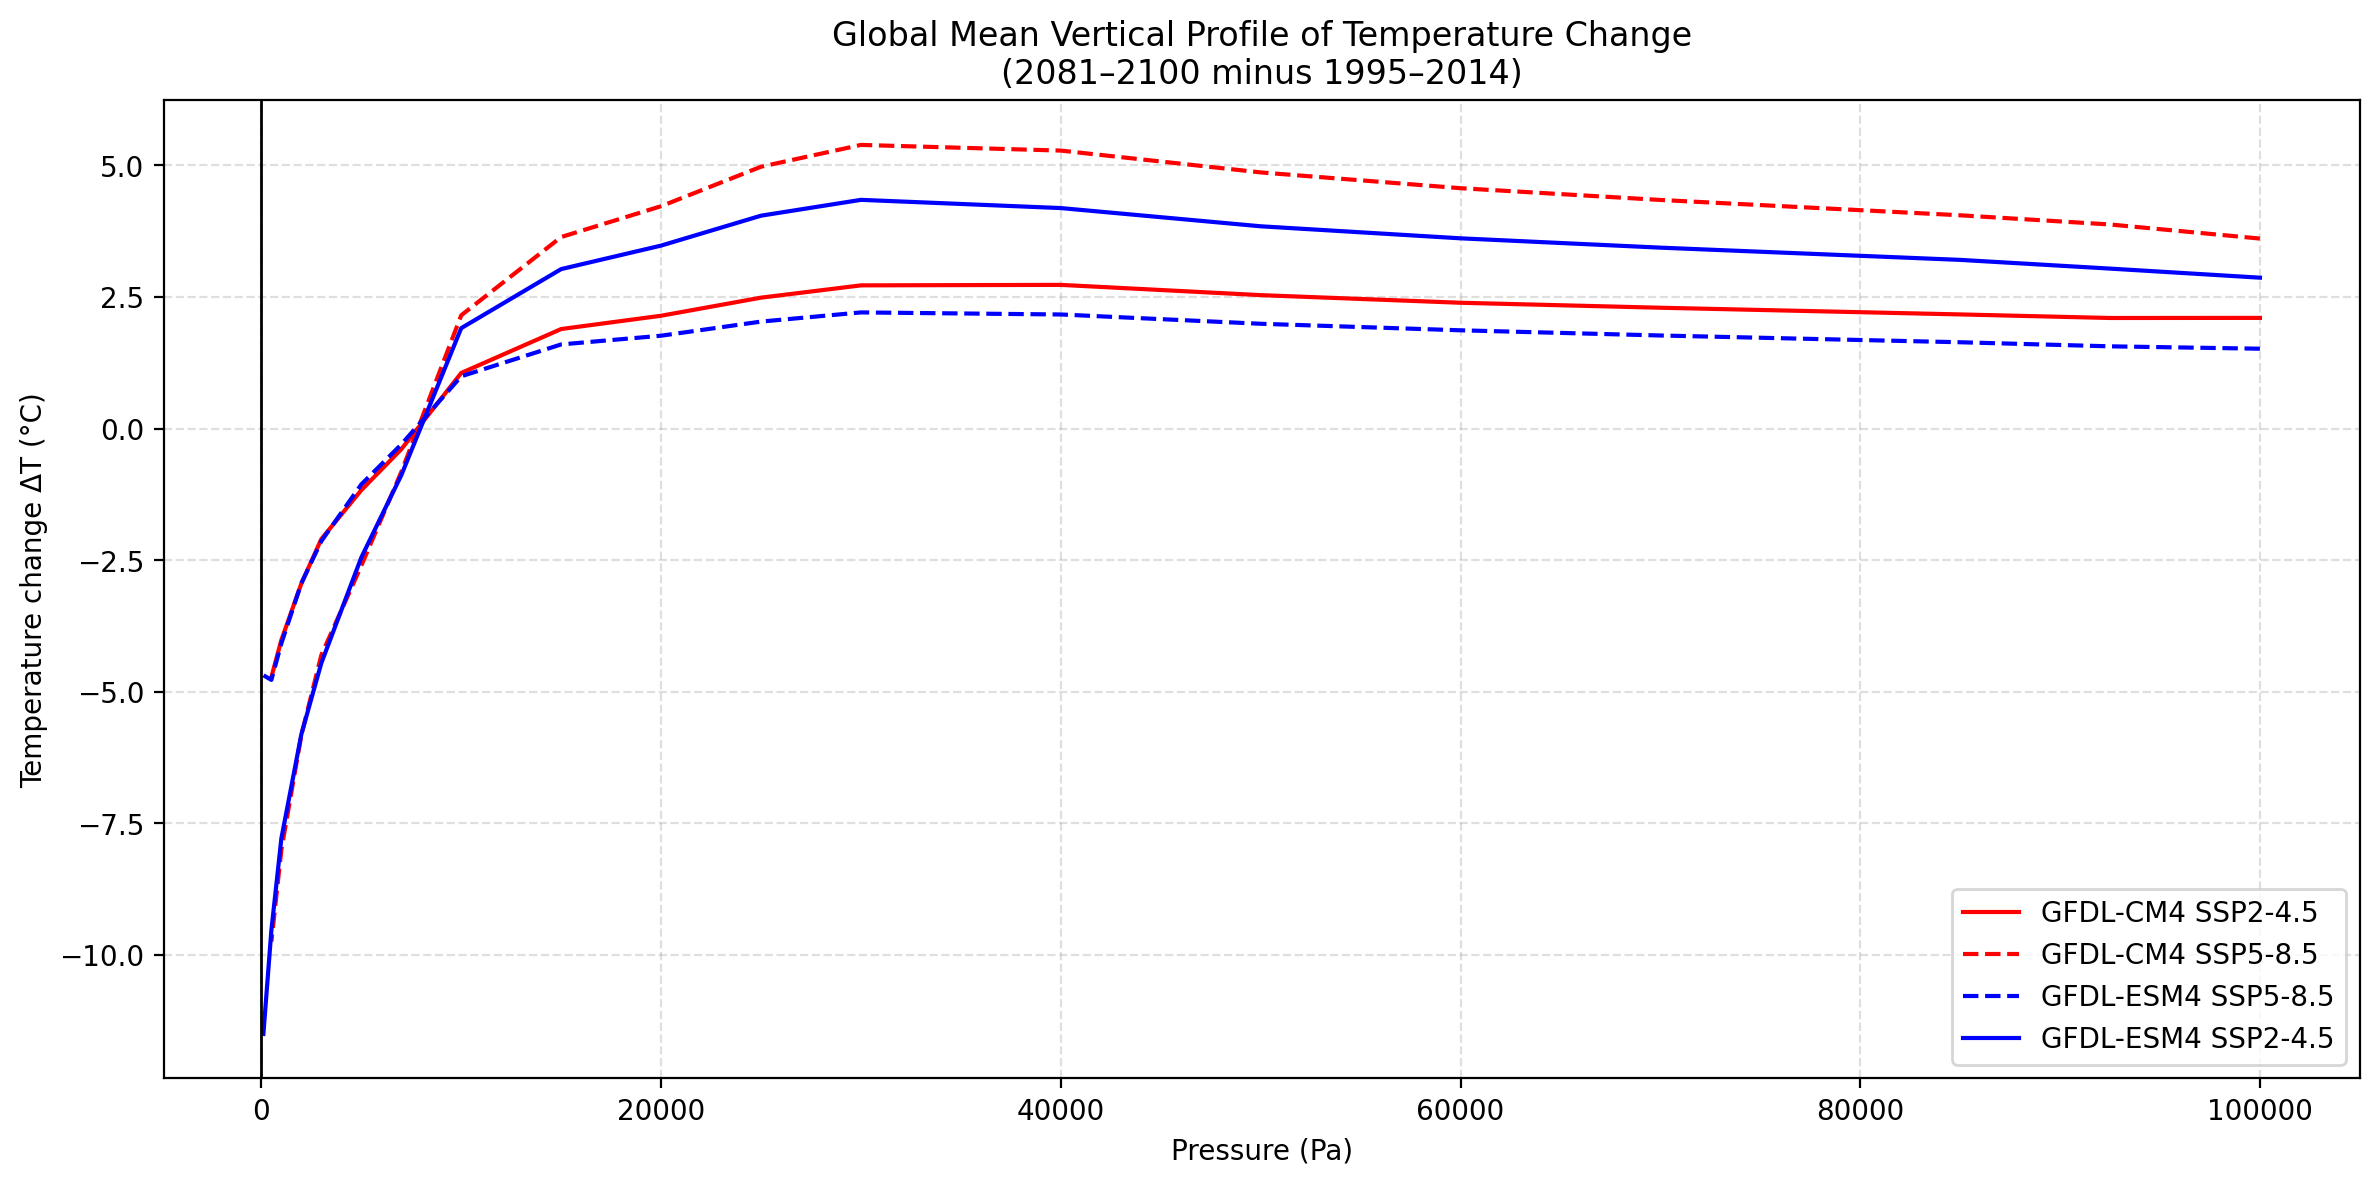

In [51]:
#Create Zonal Mean Plot 
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(
    wt_avg_GFDL_CM4_diff_SSP245_tao["plev"],
    wt_avg_GFDL_CM4_diff_SSP245_tao,
    color= 'red' ,
    linestyle="-",
    label="GFDL-CM4 SSP2-4.5"
)

ax.plot(
    wt_avg_GFDL_CM4_diff_SSP585_tao["plev"],
    wt_avg_GFDL_CM4_diff_SSP585_tao,
    color= 'red' ,
    linestyle="--",
    label="GFDL-CM4 SSP5-8.5"
)
ax.plot(
    wt_avg_GFDL_ESM4_diff_SSP585_tao["plev"],
    wt_avg_GFDL_ESM4_diff_SSP585_tao,
    color='blue',
    linestyle="--",
    label="GFDL-ESM4 SSP5-8.5"
)

ax.plot(
    wt_avg_GFDL_ESM4_diff_SSP245_tao["plev"],
    wt_avg_GFDL_ESM4_diff_SSP245_tao,
    color='blue',
    linestyle="-",
    label="GFDL-ESM4 SSP2-4.5"
)

# Reference line at zero warming
ax.axvline(0, color="k", linewidth=1)

ax.set_xlabel("Pressure (Pa)")
ax.set_ylabel("Temperature change ΔT (°C)")
ax.set_title("Global Mean Vertical Profile of Temperature Change\n(2081–2100 minus 1995–2014)")

ax.grid( linestyle="--", alpha=0.4)
ax.legend()
plt.tight_layout()
plt.show()

**Figure 7| Vertical Temperature Profile**
Global mean vertical profile of atmospheric change for 2081-2100 relative to 1995-2014. Profiles are computed by averaging over latitude and longitude at each pressure level.

In [52]:
#Create new baseline for pressure data 
GFDL_CM4_baseline_zonal_pa = gfdl_cm4_H_tao.sel(time=slice('1995-01-06','2014-12-16')).groupby("time.month").mean(dim="time")

GFDL_ESM4_baseline_zonal_pa = gfdl_ESM4_H_tao.sel(time=slice('1994-01-06','2014-12-16')).groupby("time.month").mean(dim="time")

GFDl_CM4_SSP245_zonal_pa = gfdl_cm4_245_tao.sel(time=slice('2081-01-16','2100-12-16')).groupby("time.month").mean(dim="time")

GFDl_CM4_SSP585_zonal_pa = gfdl_cm4_58_tao.sel(time=slice('2081-01-16','2100-12-16')).groupby("time.month").mean(dim="time")

GFDl_ESM4_SSP585_zonal_pa = gfdl_ESM4_585_tao.sel(time=slice('2081-01-16','2100-12-16')).groupby("time.month").mean(dim="time")

GFDl_ESM4_SSP245_zonal_pa = gfdl_ESM4_245_tao.sel(time=slice('2081-01-16','2100-12-16')).groupby("time.month").mean(dim="time")

In [53]:
#average over longitude
Zonal_anom_SSP245_CM4_pa = (GFDl_CM4_SSP245_zonal_pa - GFDL_CM4_baseline_zonal_pa).mean("longitude") 
Zonal_anom_SSP585_CM4_pa = (GFDl_CM4_SSP585_zonal_pa - GFDL_CM4_baseline_zonal_pa).mean("longitude") 
Zonal_anom_SSP245_ESM4_pa = (GFDl_ESM4_SSP245_zonal_pa - GFDL_CM4_baseline_zonal_pa).mean("longitude") 
Zonal_anom_SSP585_ESM4_pa = (GFDl_ESM4_SSP585_zonal_pa - GFDL_CM4_baseline_zonal_pa).mean("longitude") 

In [54]:
#average over time 
Zonal_anom_SSP245_CM4_pa = Zonal_anom_SSP245_CM4_pa.mean("month")
Zonal_anom_SSP585_CM4_pa = Zonal_anom_SSP585_CM4_pa.mean("month")
Zonal_anom_SSP245_ESM4_pa = Zonal_anom_SSP245_ESM4_pa.mean("month") 
Zonal_anom_SSP585_ESM4_pa = Zonal_anom_SSP585_ESM4_pa.mean("month")

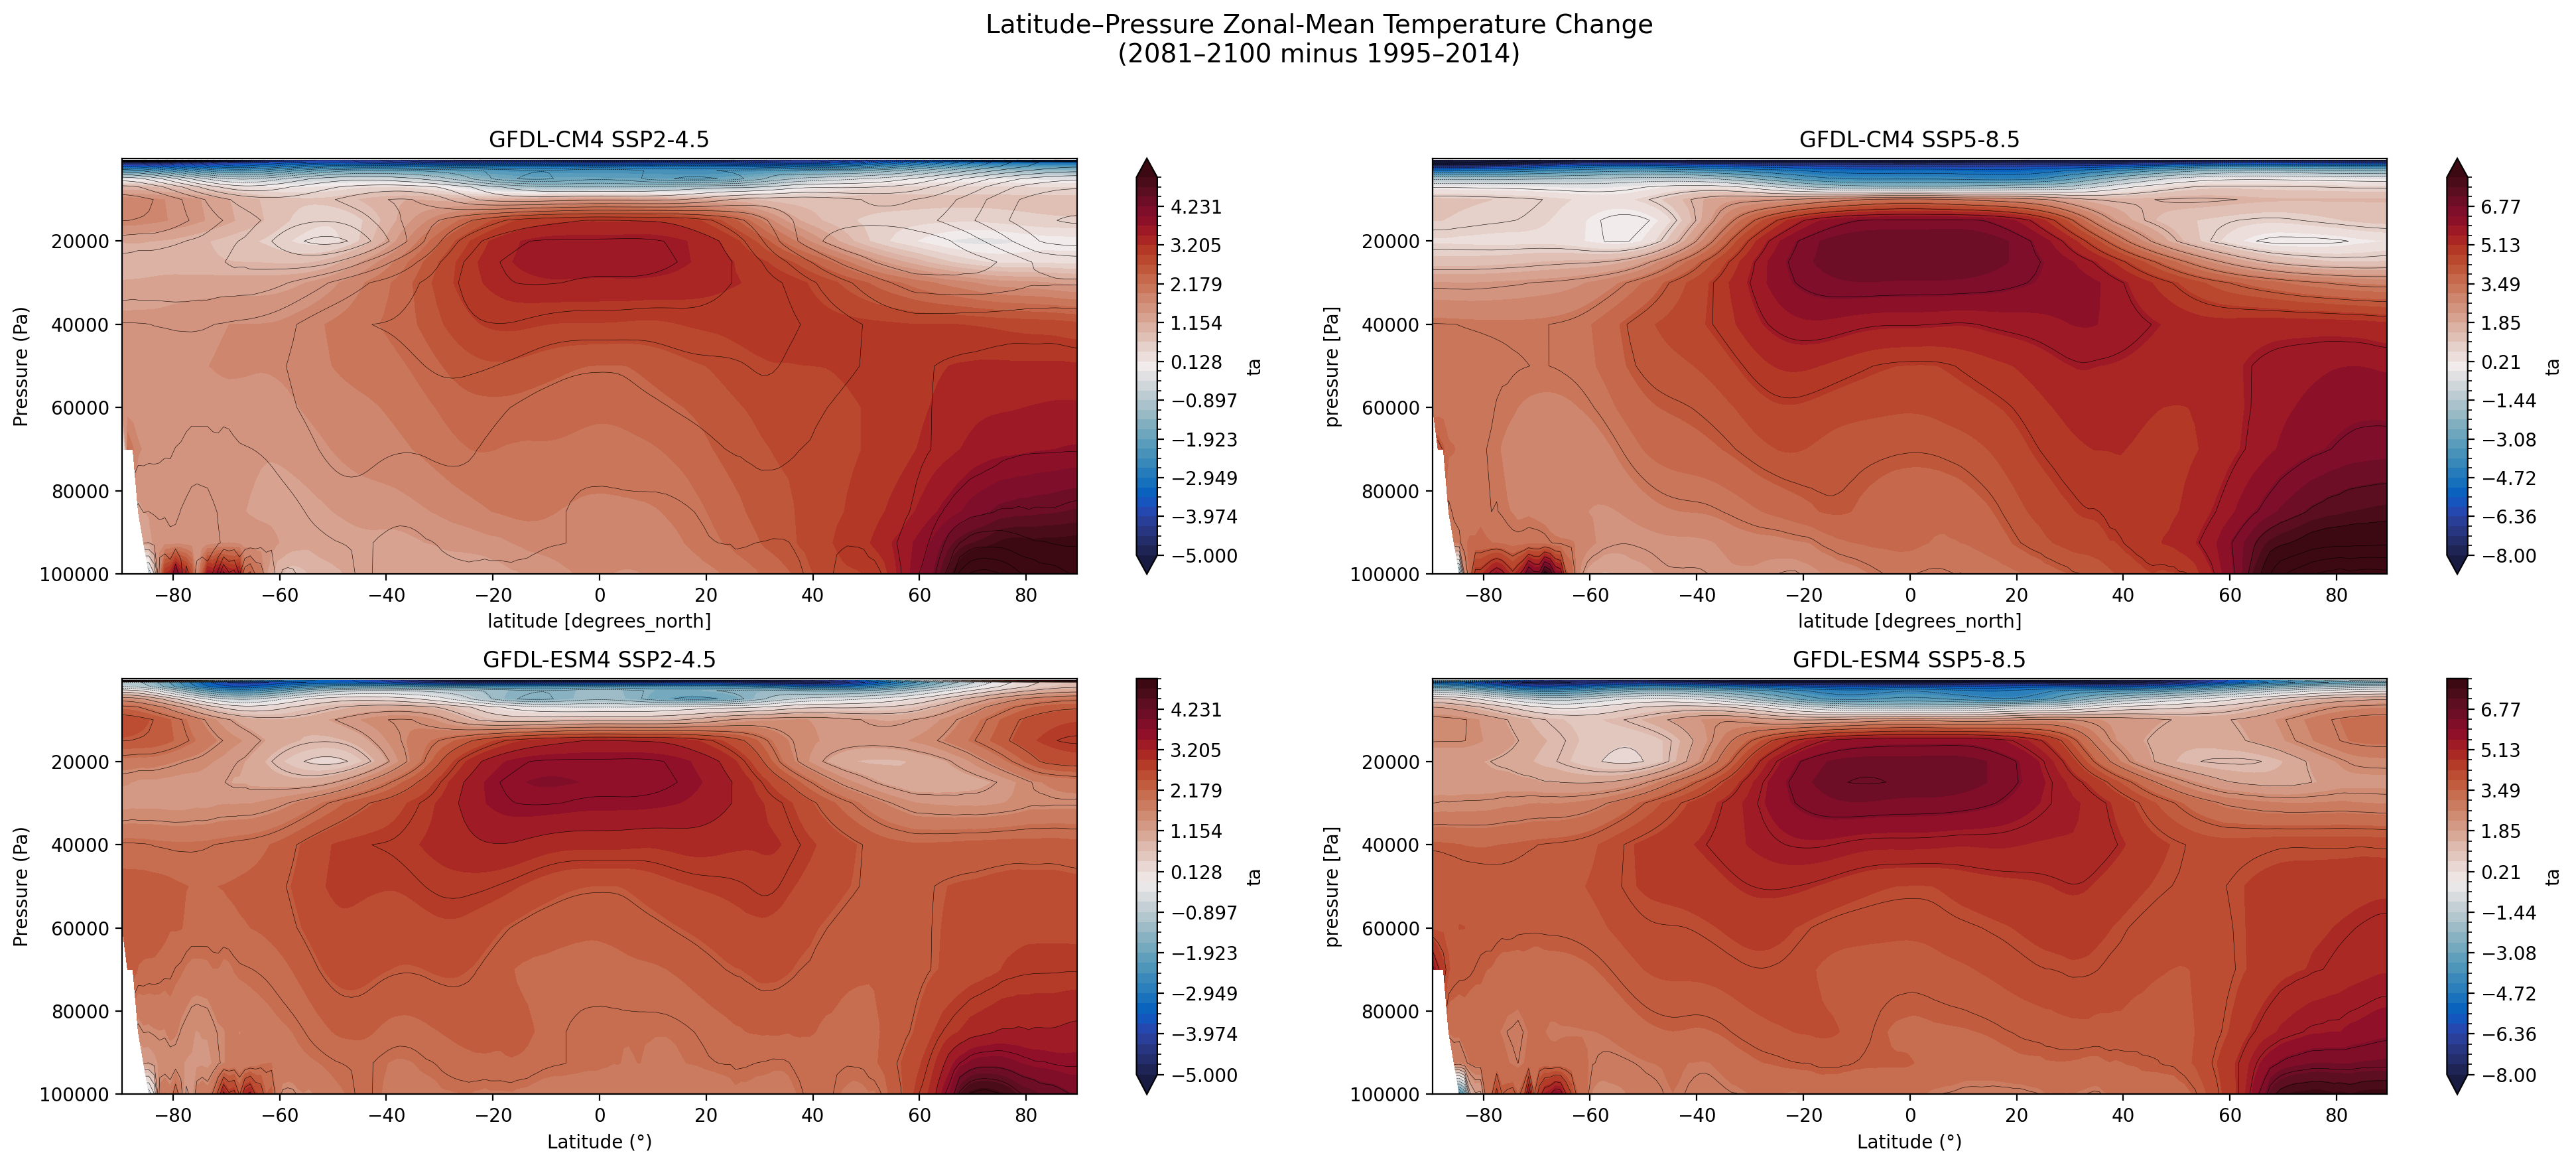

In [55]:
fig, ax = plt.subplots(2, 2, figsize=(20, 9))

# CM4 SSP2-4.5 
im = Zonal_anom_SSP245_CM4_pa.plot.contourf(
    ax=ax[0,0],
    x="latitude", y="plev",
    yincrease=False,
    levels=40,
    cmap=cmocean.cm.balance,
    vmin=-5, vmax=5,
    add_colorbar=True 
)
Zonal_anom_SSP245_ESM4_pa.plot.contour(
    ax=ax[0,0],
    x="latitude", y="plev",
    yincrease=False,
    levels=40,
    colors="black",
    linewidths=0.2,
    add_colorbar=False  
)
ax[0,0].set_title("GFDL-CM4 SSP2-4.5")


# CM4 SSP5-8.5
Zonal_anom_SSP585_CM4_pa.plot.contourf(
    ax=ax[0,1],
    x="latitude", y="plev",
    yincrease=False,
    levels=40,
    cmap=cmocean.cm.balance,
    vmin=-8, vmax=8,
    add_colorbar= True 
)
Zonal_anom_SSP585_CM4_pa.plot.contour(
    ax=ax[0,1],
    x="latitude", y="plev",
    yincrease= False ,
    levels=40,
    colors="black",
    linewidths=0.2,
    add_colorbar=False  
)
ax[0,1].set_title("GFDL-CM4 SSP5-8.5")


#  ESM4 SSP2-4.5 
Zonal_anom_SSP245_ESM4_pa.plot.contourf(
    ax=ax[1,0],
    x="latitude", y="plev",
    yincrease=False,
    levels=40,
    cmap=cmocean.cm.balance,
    vmin=-5, vmax=5,
    add_colorbar=True 
)
Zonal_anom_SSP245_ESM4_pa.plot.contour(
    ax=ax[1,0],
    x="latitude", y="plev",
    yincrease=False,
    levels=40,
    colors="black",
    linewidths=0.2,
    add_colorbar= False 
)
ax[1,0].set_title("GFDL-ESM4 SSP2-4.5")


# ESM4 SSP5-8.5 
Zonal_anom_SSP585_ESM4_pa.plot.contourf(
    ax=ax[1,1],
    x="latitude", y="plev",
    yincrease=False,
    levels=40,
    cmap=cmocean.cm.balance,
    vmin=-8, vmax=8,
    add_colorbar=True 
)
Zonal_anom_SSP585_ESM4_pa.plot.contour(
    ax=ax[1,1],
    x="latitude", y="plev",
    yincrease=False,
    levels=40,
    colors="black",
    linewidths=0.2,
    add_colorbar= False 
)
ax[1,1].set_title("GFDL-ESM4 SSP5-8.5")
# label axes
ax[1,0].set_xlabel("Latitude (°)")
ax[1,1].set_xlabel("Latitude (°)")
ax[0,0].set_ylabel("Pressure (Pa)")
ax[1,0].set_ylabel("Pressure (Pa)")
# set full plot title
fig.suptitle(
    "Latitude–Pressure Zonal-Mean Temperature Change\n"
    "(2081–2100 minus 1995–2014)",
    fontsize=14,
    y=0.97
)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**Figure 8.| Latitude-pressure zonal-mean warming**
Latitude-pressure zonal-mean atmospheric temperature change for 2081-2100 relative to the 1995-2014 baseline. Results are shown for each model and scenario.

## Summary and Conclusion 
### Overall, the projected warming patterns across different models and scenarios are consistent with IPCC AR6 findings. Stronger greenhouse gas forcings leads to larger global mean warming, amplified ocean-land contrasts and very pronounced polar amplification. From my observations differences in the models seems to affect their magnitude rather than how warming is occurring. 
(IPCC 6th Assessment, 2021)